In [1]:
!pip install wget
import os
import torch
import pandas as pd
import numpy as np
import torch
from torch import nn


ssh_config = """
Host github.com
  IdentityFile ~/.ssh/github.pem
  User davipeag
  StrictHostKeyChecking no
"""

if os.name == 'nt':
  base_path = ""
  REPO_DIR = "."
  STORE_DIR ="." 
  print("Windows")
else:
  print("Unix-like")
  REPO_DIR = "/tmp/HeartRateRegression"
  from google.colab import drive
  drive.mount('/content/drive')
  GIT_PATH = "/content/drive/My\ Drive/deeplearning_project/github.pem"
  DATA_DIR = os.path.join(REPO_DIR, "repo")
  STORE_DIR ="/content/drive/My Drive/deeplearning_project/" 
  !mkdir ~/.ssh
  !cp -u {GIT_PATH} ~/.ssh/
  !chmod u=rw,g=,o= ~/.ssh/github.pem
  !echo "{ssh_config}" > ~/.ssh/config
  !chmod u=rw,g=,o= ~/.ssh/config
  ! (cd /tmp && git clone git@github.com:davipeag/HeartRateRegression.git)
  ! (cd {REPO_DIR} && git pull )
  import sys
  sys.path.append(REPO_DIR)

def git_pull():
  ! (cd {REPO_DIR} && git pull )

git_pull()

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=eca174f2e4099ed2cafeb0b081bb80822ffb65ec90ab57620a2e564a7cb898ee
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Unix-like
Mounted at /content/drive
Cloning into 'HeartRateRegression'...
remote: Enumerating objects: 257, done.
remote: Counting objects: 100% (257/257), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 2309 (delta 152), reused 149 (delta 66), pack-reused 2052
Receiving objects: 100% (2309/2309), 151.58 MiB | 18.45 MiB/s, done.
Resolving deltas: 100% (1495/1495), done.
Already up to date.
Already up to date.


In [2]:
%%time
import random
import torch
from torch import nn
import numpy as np
args = {
    'epoch_num': 250,     # Number of epochs.
    'lr': 1.0e-3,           # Learning rate.
    'weight_decay': 10e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 0,     # Number of workers on data loader.
    'batch_size': 128,     # Mini-batch size. 128
    'batch_test': 248,     # size of test batch
    'window': 15,
    'initial_window':5,
    'clip_norm': 6.0,     # Upper limit on gradient L2 norm ###
}
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

SEED = 1234
def reset_seeds():
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

reset_seeds()

cpu


In [73]:
from data_utils import (Pamap2Handler, FormatPamap)

SUBJECTS = list(range(1,10))

handler = Pamap2Handler(DATA_DIR)
formatter = FormatPamap()
dfs_train = [formatter.transform(handler.get_protocol_subject(i)) for i in SUBJECTS]
[len(df)//200 for df in dfs_train]

[1882, 2235, 1264, 1647, 1873, 1809, 1567, 2040, 42]

In [77]:
dfs_train = dfs_train[:-1]
len(dfs_train)

8

In [66]:
git_pull()

import importlib

import PPG
import preprocessing_utils
from PPG import FullTrainer
import RegressionHR

from RegressionHR import FullTrainer
from RegressionHR import PceLstmDefaults
from RegressionHR import PceLstmModel
from RegressionHR import TrainerJoint
from RegressionHR import  UtilitiesData


importlib.reload(PPG.AttentionDefaults)
importlib.reload(PPG)
importlib.reload(PPG.UtilitiesDataXY)
importlib.reload(PPG.Models)
importlib.reload(PPG.NoHrPceLstmModel)
importlib.reload(PPG.TrainerXY)
importlib.reload(PPG.TrainerIS)
importlib.reload(PPG.FullTrainer)
importlib.reload(PceLstmDefaults)
importlib.reload(preprocessing_utils)
importlib.reload(RegressionHR)
importlib.reload(RegressionHR.FullTrainer)
importlib.reload(RegressionHR.PceLstmDefaults)
importlib.reload(PPG.UtilitiesDataXY)
importlib.reload(preprocessing_utils)
importlib.reload(RegressionHR.TrainerJoint)
importlib.reload(RegressionHR.UtilitiesData)
importlib.reload(RegressionHR.PceLstmModel)
importlib.reload(preprocessing_utils)


Already up to date.


<module 'preprocessing_utils' from '/tmp/HeartRateRegression/preprocessing_utils.py'>

In [67]:
import matplotlib.pyplot as plt
import pickle

def compute_ensemble(results):
  
  ys = [v["predictions"][0].reshape(-1).numpy() for v in results]
  min_len_y = min([len(y) for y in ys])
  ys = [y[:min_len_y] for y in ys]
  for i in range(1, len(ys)-1):
    assert np.all(ys[i] == ys[i-1])
  ps = np.stack([v["predictions"][1].reshape(-1).numpy()[:min_len_y] for v in results])

  s = ps[0]
  for p in ps[1:]:
    s = s + p

  a = s/len(ps)
  y = ys[0]

  plt.figure()

  plt.plot(a)
  plt.plot(y)

  plt.show()

  return np.mean(np.abs(a - y)), np.mean(np.abs(ps - y))



best val epoch: 1
[1/200]: loss_train: 22.900 loss_val 26.518 loss_ts 20.862
best val epoch: 2
[2/200]: loss_train: 22.109 loss_val 25.380 loss_ts 20.274
best val epoch: 3
[3/200]: loss_train: 21.462 loss_val 24.319 loss_ts 19.787
best val epoch: 4
[4/200]: loss_train: 20.927 loss_val 23.373 loss_ts 19.348
best val epoch: 5
[5/200]: loss_train: 20.458 loss_val 22.524 loss_ts 18.931
best val epoch: 6
[6/200]: loss_train: 20.051 loss_val 21.774 loss_ts 18.511
best val epoch: 7
[7/200]: loss_train: 19.686 loss_val 21.127 loss_ts 18.119
best val epoch: 8
[8/200]: loss_train: 19.349 loss_val 20.644 loss_ts 17.780
best val epoch: 9
[9/200]: loss_train: 19.045 loss_val 20.250 loss_ts 17.473
best val epoch: 10
[10/200]: loss_train: 18.754 loss_val 19.905 loss_ts 17.177
best val epoch: 11
[11/200]: loss_train: 18.534 loss_val 19.624 loss_ts 16.936
best val epoch: 12
[12/200]: loss_train: 18.395 loss_val 19.418 loss_ts 16.893
best val epoch: 13
[13/200]: loss_train: 18.376 loss_val 19.285 loss_t

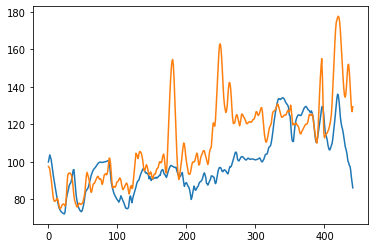

1-TS:(14.39467, 14.39467)
best val epoch: 1
[1/200]: loss_train: 21.079 loss_val 18.796 loss_ts 22.868
best val epoch: 10
[10/200]: loss_train: 18.427 loss_val 18.710 loss_ts 18.014
best val epoch: 11
[11/200]: loss_train: 18.354 loss_val 18.645 loss_ts 17.867
best val epoch: 12
[12/200]: loss_train: 18.327 loss_val 18.567 loss_ts 17.740
best val epoch: 13
[13/200]: loss_train: 18.369 loss_val 18.479 loss_ts 17.519
best val epoch: 14
[14/200]: loss_train: 18.424 loss_val 18.437 loss_ts 17.378
best val epoch: 15
[15/200]: loss_train: 18.500 loss_val 18.410 loss_ts 17.203
best val epoch: 19
[19/200]: loss_train: 19.009 loss_val 18.137 loss_ts 17.106
best val epoch: 20
[20/200]: loss_train: 18.839 loss_val 17.782 loss_ts 16.962
best val epoch: 21
[21/200]: loss_train: 18.738 loss_val 17.470 loss_ts 16.805
best val epoch: 22
[22/200]: loss_train: 18.585 loss_val 17.006 loss_ts 16.700
best val epoch: 23
[23/200]: loss_train: 18.517 loss_val 16.777 loss_ts 16.861
best val epoch: 42
[42/200]:

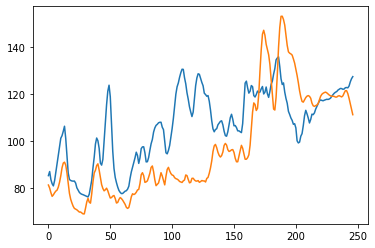

2-TS:(15.228005, 15.228005)
best val epoch: 1
[1/200]: loss_train: 19.885 loss_val 19.629 loss_ts 13.865
best val epoch: 2
[2/200]: loss_train: 19.488 loss_val 19.259 loss_ts 13.666
best val epoch: 3
[3/200]: loss_train: 19.134 loss_val 18.890 loss_ts 13.491
best val epoch: 4
[4/200]: loss_train: 18.810 loss_val 18.496 loss_ts 13.309
best val epoch: 5
[5/200]: loss_train: 18.505 loss_val 18.114 loss_ts 13.186
best val epoch: 10
[10/200]: loss_train: 17.758 loss_val 17.937 loss_ts 13.215
best val epoch: 11
[11/200]: loss_train: 17.608 loss_val 17.572 loss_ts 13.083
best val epoch: 12
[12/200]: loss_train: 17.464 loss_val 17.416 loss_ts 13.125
best val epoch: 13
[13/200]: loss_train: 17.309 loss_val 17.309 loss_ts 13.328
best val epoch: 14
[14/200]: loss_train: 17.112 loss_val 17.149 loss_ts 13.603
best val epoch: 15
[15/200]: loss_train: 16.859 loss_val 16.942 loss_ts 13.889
best val epoch: 16
[16/200]: loss_train: 16.530 loss_val 16.673 loss_ts 14.200
best val epoch: 17
[17/200]: loss_

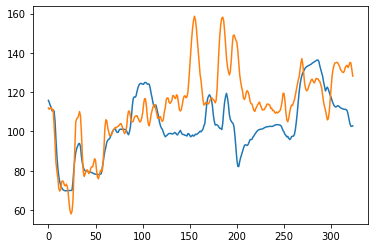

3-TS:(14.3917675, 14.3917675)
best val epoch: 1
[1/200]: loss_train: 22.018 loss_val 18.949 loss_ts 20.884
best val epoch: 2
[2/200]: loss_train: 20.782 loss_val 18.226 loss_ts 20.238
best val epoch: 3
[3/200]: loss_train: 19.795 loss_val 18.003 loss_ts 19.725
best val epoch: 4
[4/200]: loss_train: 18.910 loss_val 17.989 loss_ts 19.404
best val epoch: 14
[14/200]: loss_train: 16.990 loss_val 17.924 loss_ts 18.290
best val epoch: 15
[15/200]: loss_train: 16.864 loss_val 17.629 loss_ts 18.207
best val epoch: 16
[16/200]: loss_train: 16.826 loss_val 17.361 loss_ts 18.135
best val epoch: 17
[17/200]: loss_train: 16.826 loss_val 17.118 loss_ts 18.065
best val epoch: 18
[18/200]: loss_train: 16.839 loss_val 16.899 loss_ts 17.998
best val epoch: 19
[19/200]: loss_train: 16.842 loss_val 16.703 loss_ts 17.927
best val epoch: 20
[20/200]: loss_train: 16.826 loss_val 16.540 loss_ts 17.848
best val epoch: 21
[21/200]: loss_train: 16.779 loss_val 16.394 loss_ts 17.754
best val epoch: 22
[22/200]: l

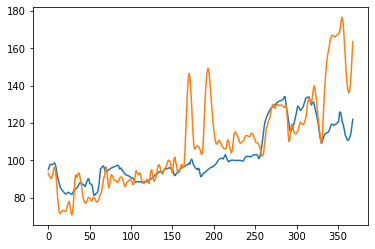

4-TS:(11.331322, 11.331322)
best val epoch: 1
[1/200]: loss_train: 19.236 loss_val 18.170 loss_ts 22.005
best val epoch: 2
[2/200]: loss_train: 18.812 loss_val 17.786 loss_ts 21.432
best val epoch: 3
[3/200]: loss_train: 18.406 loss_val 17.541 loss_ts 20.938
best val epoch: 4
[4/200]: loss_train: 18.050 loss_val 17.428 loss_ts 20.474
best val epoch: 5
[5/200]: loss_train: 17.775 loss_val 17.353 loss_ts 20.083
best val epoch: 6
[6/200]: loss_train: 17.547 loss_val 17.264 loss_ts 19.745
best val epoch: 7
[7/200]: loss_train: 17.341 loss_val 17.148 loss_ts 19.486
best val epoch: 8
[8/200]: loss_train: 17.136 loss_val 17.002 loss_ts 19.271
best val epoch: 9
[9/200]: loss_train: 16.934 loss_val 16.855 loss_ts 19.104
best val epoch: 10
[10/200]: loss_train: 16.742 loss_val 16.705 loss_ts 18.970
best val epoch: 11
[11/200]: loss_train: 16.561 loss_val 16.579 loss_ts 18.854
best val epoch: 12
[12/200]: loss_train: 16.384 loss_val 16.501 loss_ts 18.780
best val epoch: 30
[30/200]: loss_train: 1

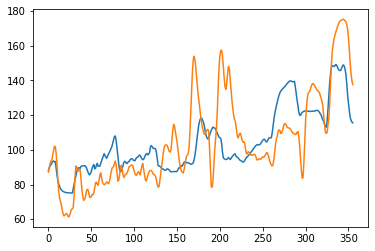

5-TS:(15.196808, 15.196808)
best val epoch: 1
[1/200]: loss_train: 18.819 loss_val 16.360 loss_ts 22.731
best val epoch: 2
[2/200]: loss_train: 18.453 loss_val 15.904 loss_ts 22.132
best val epoch: 3
[3/200]: loss_train: 18.181 loss_val 15.502 loss_ts 21.667
best val epoch: 4
[4/200]: loss_train: 17.982 loss_val 15.154 loss_ts 21.236
best val epoch: 5
[5/200]: loss_train: 17.853 loss_val 14.923 loss_ts 20.874
best val epoch: 6
[6/200]: loss_train: 17.764 loss_val 14.817 loss_ts 20.583
best val epoch: 42
[42/200]: loss_train: 12.810 loss_val 14.229 loss_ts 16.606
best val epoch: 43
[43/200]: loss_train: 12.885 loss_val 13.703 loss_ts 15.885
best val epoch: 52
[52/200]: loss_train: 12.299 loss_val 13.684 loss_ts 14.962
best val epoch: 58
[58/200]: loss_train: 10.688 loss_val 13.034 loss_ts 16.887
best val epoch: 59
[59/200]: loss_train: 10.655 loss_val 12.219 loss_ts 16.051
best val epoch: 60
[60/200]: loss_train: 10.658 loss_val 11.820 loss_ts 15.255
best val epoch: 61
[61/200]: loss_tr

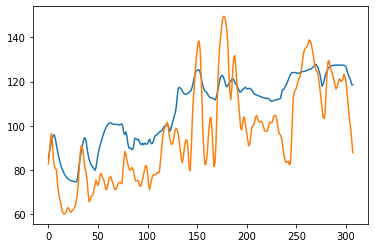

6-TS:(14.264097, 14.264097)
best val epoch: 1
[1/200]: loss_train: 18.318 loss_val 19.016 loss_ts 26.163
best val epoch: 2
[2/200]: loss_train: 17.835 loss_val 18.652 loss_ts 26.718
best val epoch: 3
[3/200]: loss_train: 17.388 loss_val 18.298 loss_ts 27.476
best val epoch: 4
[4/200]: loss_train: 16.976 loss_val 18.047 loss_ts 28.561
best val epoch: 14
[14/200]: loss_train: 15.209 loss_val 17.766 loss_ts 34.766
best val epoch: 15
[15/200]: loss_train: 15.087 loss_val 17.431 loss_ts 34.330
best val epoch: 16
[16/200]: loss_train: 14.984 loss_val 17.073 loss_ts 33.735
best val epoch: 17
[17/200]: loss_train: 14.867 loss_val 16.724 loss_ts 33.165
best val epoch: 18
[18/200]: loss_train: 14.732 loss_val 16.427 loss_ts 32.615
best val epoch: 19
[19/200]: loss_train: 14.585 loss_val 16.272 loss_ts 32.107
best val epoch: 28
[28/200]: loss_train: 13.578 loss_val 16.187 loss_ts 29.043
best val epoch: 29
[29/200]: loss_train: 13.444 loss_val 16.038 loss_ts 28.668
best val epoch: 30
[30/200]: los

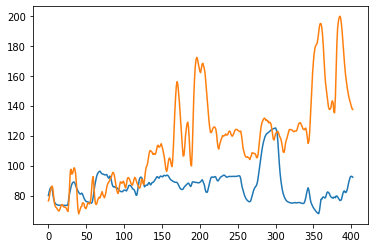

7-TS:(31.104006, 31.104006)
best val epoch: 1
[1/200]: loss_train: 19.965 loss_val 17.853 loss_ts 22.833
best val epoch: 2
[2/200]: loss_train: 19.506 loss_val 17.461 loss_ts 23.259
best val epoch: 3
[3/200]: loss_train: 19.094 loss_val 17.178 loss_ts 23.761
best val epoch: 4
[4/200]: loss_train: 18.670 loss_val 16.962 loss_ts 24.313
best val epoch: 5
[5/200]: loss_train: 18.246 loss_val 16.772 loss_ts 25.014
best val epoch: 6
[6/200]: loss_train: 17.840 loss_val 16.599 loss_ts 25.918
best val epoch: 7
[7/200]: loss_train: 17.486 loss_val 16.436 loss_ts 27.030
best val epoch: 8
[8/200]: loss_train: 17.227 loss_val 16.308 loss_ts 28.310
best val epoch: 15
[15/200]: loss_train: 16.445 loss_val 16.225 loss_ts 28.755
best val epoch: 16
[16/200]: loss_train: 16.329 loss_val 16.160 loss_ts 28.107
best val epoch: 17
[17/200]: loss_train: 16.237 loss_val 16.099 loss_ts 27.537
best val epoch: 18
[18/200]: loss_train: 16.160 loss_val 16.018 loss_ts 27.058
best val epoch: 19
[19/200]: loss_train:

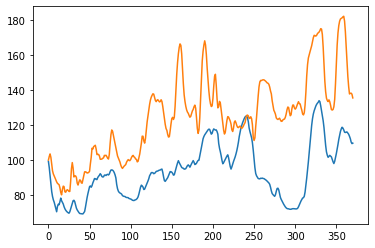

0-TS:(30.78168, 30.78168)
best val epoch: 1
[1/200]: loss_train: 19.790 loss_val 16.721 loss_ts 21.122
best val epoch: 6
[6/200]: loss_train: 19.379 loss_val 16.300 loss_ts 21.002
best val epoch: 7
[7/200]: loss_train: 19.279 loss_val 15.935 loss_ts 20.514
best val epoch: 8
[8/200]: loss_train: 19.203 loss_val 15.616 loss_ts 20.020
best val epoch: 9
[9/200]: loss_train: 19.143 loss_val 15.345 loss_ts 19.534
best val epoch: 10
[10/200]: loss_train: 19.105 loss_val 15.138 loss_ts 19.108
best val epoch: 11
[11/200]: loss_train: 19.096 loss_val 14.995 loss_ts 18.706
best val epoch: 12
[12/200]: loss_train: 19.113 loss_val 14.959 loss_ts 18.463
best val epoch: 13
[13/200]: loss_train: 19.099 loss_val 14.910 loss_ts 18.373
best val epoch: 14
[14/200]: loss_train: 19.048 loss_val 14.741 loss_ts 18.303
best val epoch: 15
[15/200]: loss_train: 18.983 loss_val 14.545 loss_ts 18.283
best val epoch: 16
[16/200]: loss_train: 18.905 loss_val 14.402 loss_ts 18.361
best val epoch: 17
[17/200]: loss_tr

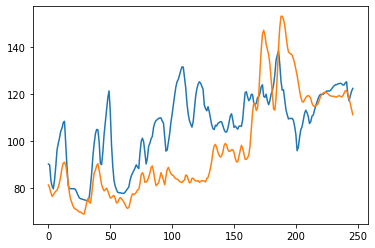

2-TS:(15.05606, 15.27116)
best val epoch: 1
[1/200]: loss_train: 19.981 loss_val 22.388 loss_ts 13.107
best val epoch: 2
[2/200]: loss_train: 19.589 loss_val 22.150 loss_ts 12.829
best val epoch: 3
[3/200]: loss_train: 19.200 loss_val 21.936 loss_ts 12.580
best val epoch: 4
[4/200]: loss_train: 18.825 loss_val 21.733 loss_ts 12.366
best val epoch: 5
[5/200]: loss_train: 18.513 loss_val 21.542 loss_ts 12.175
best val epoch: 6
[6/200]: loss_train: 18.316 loss_val 21.414 loss_ts 12.026
best val epoch: 7
[7/200]: loss_train: 18.193 loss_val 21.339 loss_ts 11.882
best val epoch: 8
[8/200]: loss_train: 18.084 loss_val 21.307 loss_ts 11.792
best val epoch: 18
[18/200]: loss_train: 17.175 loss_val 21.237 loss_ts 11.705
best val epoch: 19
[19/200]: loss_train: 17.072 loss_val 21.129 loss_ts 11.704
best val epoch: 20
[20/200]: loss_train: 16.960 loss_val 21.022 loss_ts 11.709
best val epoch: 21
[21/200]: loss_train: 16.846 loss_val 20.913 loss_ts 11.715
best val epoch: 22
[22/200]: loss_train: 1

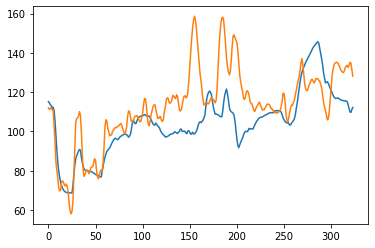

3-TS:(12.44389, 13.6905575)
best val epoch: 1
[1/200]: loss_train: 25.339 loss_val 15.514 loss_ts 20.211
best val epoch: 2
[2/200]: loss_train: 24.243 loss_val 14.905 loss_ts 19.401
best val epoch: 3
[3/200]: loss_train: 23.342 loss_val 14.429 loss_ts 18.731
best val epoch: 4
[4/200]: loss_train: 22.622 loss_val 14.047 loss_ts 18.223
best val epoch: 5
[5/200]: loss_train: 22.020 loss_val 13.785 loss_ts 17.844
best val epoch: 6
[6/200]: loss_train: 21.460 loss_val 13.610 loss_ts 17.559
best val epoch: 7
[7/200]: loss_train: 20.943 loss_val 13.497 loss_ts 17.341
best val epoch: 8
[8/200]: loss_train: 20.459 loss_val 13.459 loss_ts 17.140
best val epoch: 9
[9/200]: loss_train: 19.996 loss_val 13.432 loss_ts 16.931
best val epoch: 72
[72/200]: loss_train: 11.692 loss_val 13.323 loss_ts 12.762
best val epoch: 73
[73/200]: loss_train: 11.571 loss_val 12.784 loss_ts 12.317
best val epoch: 82
[82/200]: loss_train: 11.403 loss_val 11.987 loss_ts 12.611
best val epoch: 85
[85/200]: loss_train: 1

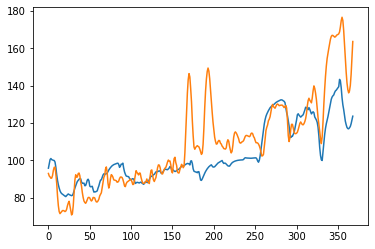

4-TS:(10.618854, 10.7191925)
best val epoch: 1
[1/200]: loss_train: 20.940 loss_val 21.023 loss_ts 21.430
best val epoch: 2
[2/200]: loss_train: 20.461 loss_val 20.395 loss_ts 21.105
best val epoch: 3
[3/200]: loss_train: 20.026 loss_val 19.814 loss_ts 20.817
best val epoch: 4
[4/200]: loss_train: 19.615 loss_val 19.288 loss_ts 20.603
best val epoch: 5
[5/200]: loss_train: 19.223 loss_val 18.794 loss_ts 20.449
best val epoch: 6
[6/200]: loss_train: 18.849 loss_val 18.314 loss_ts 20.298
best val epoch: 7
[7/200]: loss_train: 18.487 loss_val 17.860 loss_ts 20.141
best val epoch: 8
[8/200]: loss_train: 18.153 loss_val 17.438 loss_ts 19.981
best val epoch: 9
[9/200]: loss_train: 17.871 loss_val 17.051 loss_ts 19.833
best val epoch: 10
[10/200]: loss_train: 17.648 loss_val 16.718 loss_ts 19.683
best val epoch: 11
[11/200]: loss_train: 17.486 loss_val 16.466 loss_ts 19.577
best val epoch: 12
[12/200]: loss_train: 17.347 loss_val 16.269 loss_ts 19.496
best val epoch: 13
[13/200]: loss_train: 

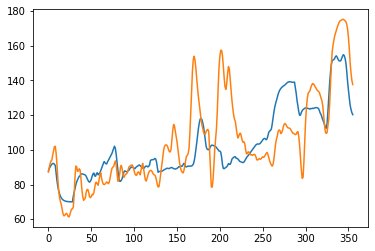

5-TS:(13.828807, 14.280116)
best val epoch: 1
[1/200]: loss_train: 19.977 loss_val 22.638 loss_ts 21.609
best val epoch: 2
[2/200]: loss_train: 19.494 loss_val 21.782 loss_ts 21.878
best val epoch: 3
[3/200]: loss_train: 19.110 loss_val 20.974 loss_ts 22.084
best val epoch: 4
[4/200]: loss_train: 18.769 loss_val 20.192 loss_ts 22.165
best val epoch: 5
[5/200]: loss_train: 18.459 loss_val 19.439 loss_ts 22.133
best val epoch: 6
[6/200]: loss_train: 18.165 loss_val 18.696 loss_ts 22.024
best val epoch: 7
[7/200]: loss_train: 17.912 loss_val 17.941 loss_ts 21.840
best val epoch: 8
[8/200]: loss_train: 17.710 loss_val 17.176 loss_ts 21.589
best val epoch: 9
[9/200]: loss_train: 17.607 loss_val 16.534 loss_ts 21.325
best val epoch: 10
[10/200]: loss_train: 17.569 loss_val 16.140 loss_ts 21.084
best val epoch: 11
[11/200]: loss_train: 17.520 loss_val 16.016 loss_ts 20.923
best val epoch: 38
[38/200]: loss_train: 15.032 loss_val 15.870 loss_ts 17.136
best val epoch: 39
[39/200]: loss_train: 1

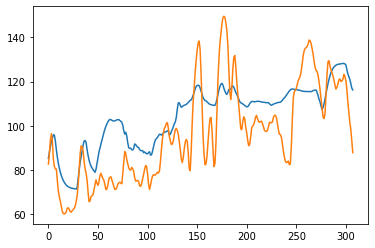

6-TS:(13.123673, 13.551992)
best val epoch: 1
[1/200]: loss_train: 20.232 loss_val 18.729 loss_ts 27.092
best val epoch: 2
[2/200]: loss_train: 19.911 loss_val 18.204 loss_ts 27.608
best val epoch: 3
[3/200]: loss_train: 19.605 loss_val 17.689 loss_ts 28.181
best val epoch: 4
[4/200]: loss_train: 19.312 loss_val 17.173 loss_ts 28.934
best val epoch: 5
[5/200]: loss_train: 19.018 loss_val 16.642 loss_ts 29.887
best val epoch: 6
[6/200]: loss_train: 18.731 loss_val 16.096 loss_ts 31.066
best val epoch: 7
[7/200]: loss_train: 18.430 loss_val 15.523 loss_ts 32.522
best val epoch: 8
[8/200]: loss_train: 18.128 loss_val 14.950 loss_ts 34.156
best val epoch: 9
[9/200]: loss_train: 17.824 loss_val 14.387 loss_ts 36.073
best val epoch: 10
[10/200]: loss_train: 17.508 loss_val 13.808 loss_ts 38.239
best val epoch: 11
[11/200]: loss_train: 17.195 loss_val 13.336 loss_ts 40.449
best val epoch: 12
[12/200]: loss_train: 16.920 loss_val 12.911 loss_ts 43.026
best val epoch: 13
[13/200]: loss_train: 1

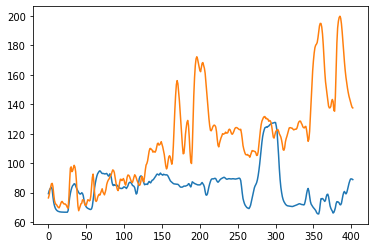

7-TS:(33.205807, 33.380177)
best val epoch: 1
[1/200]: loss_train: 18.510 loss_val 22.853 loss_ts 19.492
best val epoch: 2
[2/200]: loss_train: 18.026 loss_val 21.907 loss_ts 20.303
best val epoch: 3
[3/200]: loss_train: 17.612 loss_val 21.001 loss_ts 21.186
best val epoch: 4
[4/200]: loss_train: 17.266 loss_val 20.146 loss_ts 22.135
best val epoch: 5
[5/200]: loss_train: 16.995 loss_val 19.334 loss_ts 23.128
best val epoch: 6
[6/200]: loss_train: 16.795 loss_val 18.653 loss_ts 24.170
best val epoch: 7
[7/200]: loss_train: 16.650 loss_val 18.183 loss_ts 25.135
best val epoch: 8
[8/200]: loss_train: 16.538 loss_val 17.845 loss_ts 25.923
best val epoch: 9
[9/200]: loss_train: 16.451 loss_val 17.579 loss_ts 26.538
best val epoch: 10
[10/200]: loss_train: 16.370 loss_val 17.352 loss_ts 26.948
best val epoch: 11
[11/200]: loss_train: 16.289 loss_val 17.183 loss_ts 27.131
best val epoch: 12
[12/200]: loss_train: 16.205 loss_val 17.066 loss_ts 27.129
best val epoch: 13
[13/200]: loss_train: 1

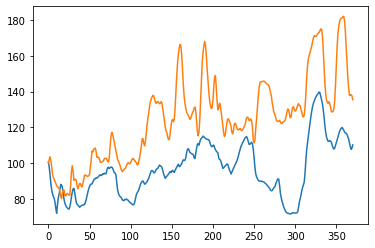

0-TS:(28.108078, 28.307693)
best val epoch: 1
[1/200]: loss_train: 19.687 loss_val 23.600 loss_ts 19.476
best val epoch: 3
[3/200]: loss_train: 18.179 loss_val 23.597 loss_ts 18.065
best val epoch: 4
[4/200]: loss_train: 17.560 loss_val 23.471 loss_ts 17.350
best val epoch: 5
[5/200]: loss_train: 17.397 loss_val 23.202 loss_ts 16.859
best val epoch: 6
[6/200]: loss_train: 17.505 loss_val 22.938 loss_ts 16.832
best val epoch: 7
[7/200]: loss_train: 17.505 loss_val 22.685 loss_ts 16.897
best val epoch: 8
[8/200]: loss_train: 17.348 loss_val 22.421 loss_ts 16.748
best val epoch: 9
[9/200]: loss_train: 17.114 loss_val 22.196 loss_ts 16.478
best val epoch: 10
[10/200]: loss_train: 16.888 loss_val 22.073 loss_ts 16.200
best val epoch: 11
[11/200]: loss_train: 16.733 loss_val 22.022 loss_ts 15.949
best val epoch: 23
[23/200]: loss_train: 15.591 loss_val 21.945 loss_ts 15.345
best val epoch: 24
[24/200]: loss_train: 15.522 loss_val 21.798 loss_ts 15.372
best val epoch: 25
[25/200]: loss_train:

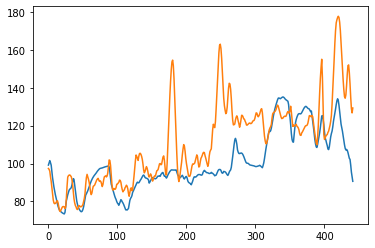

1-TS:(13.304617, 13.579403)
best val epoch: 1
[1/200]: loss_train: 18.788 loss_val 19.541 loss_ts 13.357
best val epoch: 2
[2/200]: loss_train: 18.580 loss_val 19.176 loss_ts 12.795
best val epoch: 3
[3/200]: loss_train: 18.403 loss_val 18.883 loss_ts 12.461
best val epoch: 4
[4/200]: loss_train: 18.209 loss_val 18.691 loss_ts 12.109
best val epoch: 5
[5/200]: loss_train: 18.117 loss_val 18.615 loss_ts 11.848
best val epoch: 6
[6/200]: loss_train: 18.060 loss_val 18.594 loss_ts 11.769
best val epoch: 7
[7/200]: loss_train: 17.958 loss_val 18.563 loss_ts 11.778
best val epoch: 8
[8/200]: loss_train: 17.797 loss_val 18.474 loss_ts 11.795
best val epoch: 9
[9/200]: loss_train: 17.612 loss_val 18.331 loss_ts 11.889
best val epoch: 10
[10/200]: loss_train: 17.449 loss_val 18.165 loss_ts 12.133
best val epoch: 11
[11/200]: loss_train: 17.315 loss_val 18.026 loss_ts 12.381
best val epoch: 12
[12/200]: loss_train: 17.181 loss_val 17.870 loss_ts 12.559
best val epoch: 13
[13/200]: loss_train: 1

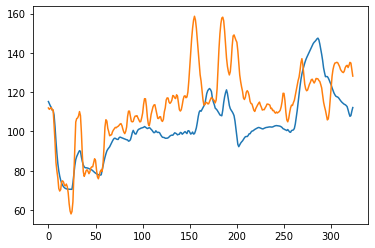

3-TS:(13.826511, 14.918001)
best val epoch: 1
[1/200]: loss_train: 21.173 loss_val 20.870 loss_ts 20.718
best val epoch: 2
[2/200]: loss_train: 20.128 loss_val 19.543 loss_ts 19.977
best val epoch: 3
[3/200]: loss_train: 19.368 loss_val 18.720 loss_ts 19.477
best val epoch: 4
[4/200]: loss_train: 18.831 loss_val 18.228 loss_ts 19.115
best val epoch: 5
[5/200]: loss_train: 18.406 loss_val 17.890 loss_ts 18.831
best val epoch: 6
[6/200]: loss_train: 18.073 loss_val 17.698 loss_ts 18.588
best val epoch: 7
[7/200]: loss_train: 17.834 loss_val 17.624 loss_ts 18.376
best val epoch: 8
[8/200]: loss_train: 17.674 loss_val 17.575 loss_ts 18.193
best val epoch: 16
[16/200]: loss_train: 16.941 loss_val 17.551 loss_ts 17.738
best val epoch: 17
[17/200]: loss_train: 16.837 loss_val 17.423 loss_ts 17.742
best val epoch: 18
[18/200]: loss_train: 16.733 loss_val 17.312 loss_ts 17.769
best val epoch: 19
[19/200]: loss_train: 16.627 loss_val 17.218 loss_ts 17.788
best val epoch: 20
[20/200]: loss_train:

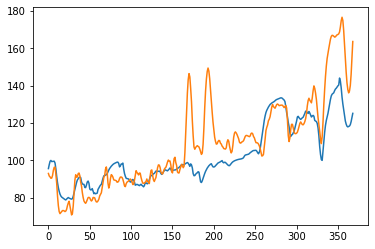

4-TS:(10.326303, 10.503827)
best val epoch: 1
[1/200]: loss_train: 20.048 loss_val 21.147 loss_ts 23.181
best val epoch: 2
[2/200]: loss_train: 19.655 loss_val 20.825 loss_ts 22.628
best val epoch: 3
[3/200]: loss_train: 19.349 loss_val 20.544 loss_ts 22.158
best val epoch: 4
[4/200]: loss_train: 19.102 loss_val 20.281 loss_ts 21.761
best val epoch: 5
[5/200]: loss_train: 18.898 loss_val 20.044 loss_ts 21.412
best val epoch: 6
[6/200]: loss_train: 18.723 loss_val 19.799 loss_ts 21.098
best val epoch: 7
[7/200]: loss_train: 18.554 loss_val 19.553 loss_ts 20.792
best val epoch: 8
[8/200]: loss_train: 18.387 loss_val 19.308 loss_ts 20.503
best val epoch: 9
[9/200]: loss_train: 18.229 loss_val 19.058 loss_ts 20.226
best val epoch: 10
[10/200]: loss_train: 18.082 loss_val 18.799 loss_ts 19.967
best val epoch: 11
[11/200]: loss_train: 17.947 loss_val 18.533 loss_ts 19.721
best val epoch: 12
[12/200]: loss_train: 17.837 loss_val 18.268 loss_ts 19.497
best val epoch: 13
[13/200]: loss_train: 1

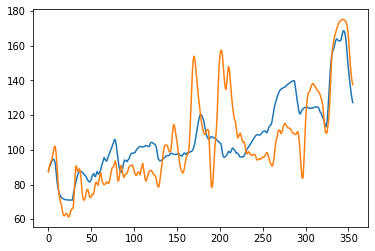

5-TS:(13.599538, 15.218418)
best val epoch: 1
[1/200]: loss_train: 18.238 loss_val 16.219 loss_ts 22.327
best val epoch: 2
[2/200]: loss_train: 17.767 loss_val 15.968 loss_ts 22.431
best val epoch: 4
[4/200]: loss_train: 17.343 loss_val 15.924 loss_ts 22.605
best val epoch: 5
[5/200]: loss_train: 17.087 loss_val 15.686 loss_ts 22.456
best val epoch: 6
[6/200]: loss_train: 16.795 loss_val 15.323 loss_ts 22.164
best val epoch: 7
[7/200]: loss_train: 16.535 loss_val 14.893 loss_ts 21.724
best val epoch: 8
[8/200]: loss_train: 16.343 loss_val 14.446 loss_ts 21.124
best val epoch: 9
[9/200]: loss_train: 16.130 loss_val 14.066 loss_ts 20.483
best val epoch: 10
[10/200]: loss_train: 15.871 loss_val 13.802 loss_ts 19.847
best val epoch: 11
[11/200]: loss_train: 15.587 loss_val 13.578 loss_ts 19.180
best val epoch: 12
[12/200]: loss_train: 15.376 loss_val 13.270 loss_ts 18.417
best val epoch: 13
[13/200]: loss_train: 15.166 loss_val 12.951 loss_ts 17.822
best val epoch: 14
[14/200]: loss_train:

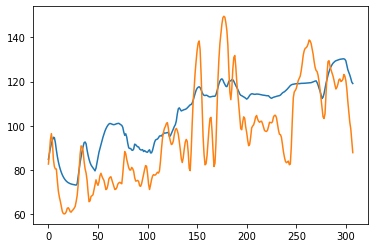

6-TS:(13.523622, 14.011678)
best val epoch: 1
[1/200]: loss_train: 21.432 loss_val 20.458 loss_ts 27.312
best val epoch: 2
[2/200]: loss_train: 20.828 loss_val 19.860 loss_ts 26.678
best val epoch: 3
[3/200]: loss_train: 20.248 loss_val 19.316 loss_ts 26.255
best val epoch: 4
[4/200]: loss_train: 19.675 loss_val 18.824 loss_ts 26.081
best val epoch: 5
[5/200]: loss_train: 19.119 loss_val 18.375 loss_ts 26.163
best val epoch: 6
[6/200]: loss_train: 18.577 loss_val 17.958 loss_ts 26.577
best val epoch: 7
[7/200]: loss_train: 18.092 loss_val 17.517 loss_ts 27.105
best val epoch: 8
[8/200]: loss_train: 17.721 loss_val 17.061 loss_ts 27.810
best val epoch: 9
[9/200]: loss_train: 17.616 loss_val 17.060 loss_ts 29.222
best val epoch: 12
[12/200]: loss_train: 17.598 loss_val 16.907 loss_ts 31.287
best val epoch: 13
[13/200]: loss_train: 17.386 loss_val 16.555 loss_ts 30.668
best val epoch: 14
[14/200]: loss_train: 17.207 loss_val 16.192 loss_ts 29.949
best val epoch: 15
[15/200]: loss_train: 1

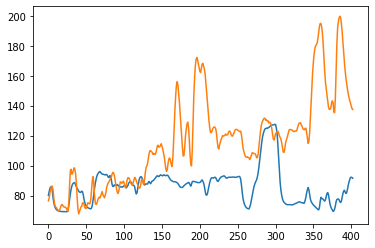

7-TS:(31.32678, 31.674105)
best val epoch: 1
[1/200]: loss_train: 22.666 loss_val 14.745 loss_ts 22.912
best val epoch: 2
[2/200]: loss_train: 21.969 loss_val 14.571 loss_ts 22.592
best val epoch: 3
[3/200]: loss_train: 21.335 loss_val 14.446 loss_ts 22.388
best val epoch: 4
[4/200]: loss_train: 20.760 loss_val 14.350 loss_ts 22.232
best val epoch: 5
[5/200]: loss_train: 20.242 loss_val 14.301 loss_ts 22.118
best val epoch: 30
[30/200]: loss_train: 16.376 loss_val 14.280 loss_ts 25.525
best val epoch: 31
[31/200]: loss_train: 16.282 loss_val 14.260 loss_ts 25.655
best val epoch: 32
[32/200]: loss_train: 16.168 loss_val 14.249 loss_ts 25.840
best val epoch: 40
[40/200]: loss_train: 14.615 loss_val 14.006 loss_ts 26.311
best val epoch: 41
[41/200]: loss_train: 14.331 loss_val 13.674 loss_ts 26.158
best val epoch: 42
[42/200]: loss_train: 14.053 loss_val 13.314 loss_ts 25.862
best val epoch: 43
[43/200]: loss_train: 13.896 loss_val 12.914 loss_ts 26.477
best val epoch: 54
[54/200]: loss_t

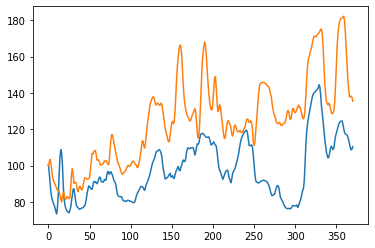

0-TS:(26.984955, 27.257496)
best val epoch: 1
[1/200]: loss_train: 19.032 loss_val 25.300 loss_ts 17.360
best val epoch: 2
[2/200]: loss_train: 18.321 loss_val 25.092 loss_ts 16.965
best val epoch: 3
[3/200]: loss_train: 17.825 loss_val 24.966 loss_ts 16.834
best val epoch: 4
[4/200]: loss_train: 17.547 loss_val 24.877 loss_ts 16.793
best val epoch: 5
[5/200]: loss_train: 17.406 loss_val 24.784 loss_ts 16.767
best val epoch: 6
[6/200]: loss_train: 17.308 loss_val 24.673 loss_ts 16.693
best val epoch: 7
[7/200]: loss_train: 17.210 loss_val 24.568 loss_ts 16.582
best val epoch: 8
[8/200]: loss_train: 17.116 loss_val 24.438 loss_ts 16.458
best val epoch: 9
[9/200]: loss_train: 17.047 loss_val 24.289 loss_ts 16.324
best val epoch: 10
[10/200]: loss_train: 16.971 loss_val 24.119 loss_ts 16.258
best val epoch: 11
[11/200]: loss_train: 16.903 loss_val 23.939 loss_ts 16.280
best val epoch: 12
[12/200]: loss_train: 16.847 loss_val 23.806 loss_ts 16.303
best val epoch: 13
[13/200]: loss_train: 1

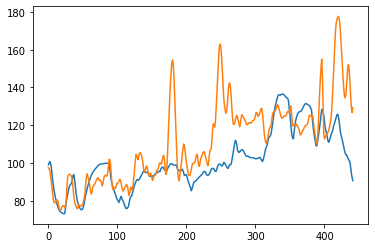

1-TS:(13.105531, 13.516431)
best val epoch: 1
[1/200]: loss_train: 20.360 loss_val 16.739 loss_ts 22.813
best val epoch: 2
[2/200]: loss_train: 19.979 loss_val 16.733 loss_ts 22.317
best val epoch: 3
[3/200]: loss_train: 19.667 loss_val 16.642 loss_ts 21.869
best val epoch: 4
[4/200]: loss_train: 19.444 loss_val 16.506 loss_ts 21.548
best val epoch: 5
[5/200]: loss_train: 19.327 loss_val 16.331 loss_ts 21.504
best val epoch: 6
[6/200]: loss_train: 19.171 loss_val 15.986 loss_ts 21.149
best val epoch: 7
[7/200]: loss_train: 18.970 loss_val 15.560 loss_ts 20.609
best val epoch: 8
[8/200]: loss_train: 18.814 loss_val 15.232 loss_ts 20.145
best val epoch: 9
[9/200]: loss_train: 18.690 loss_val 14.973 loss_ts 19.770
best val epoch: 10
[10/200]: loss_train: 18.607 loss_val 14.769 loss_ts 19.539
best val epoch: 11
[11/200]: loss_train: 18.519 loss_val 14.595 loss_ts 19.290
best val epoch: 12
[12/200]: loss_train: 18.352 loss_val 14.534 loss_ts 18.907
best val epoch: 37
[37/200]: loss_train: 1

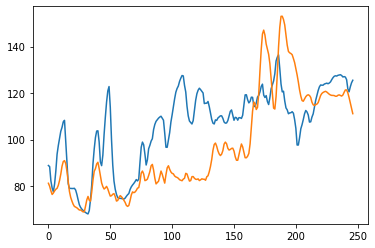

2-TS:(14.798356, 15.496121)
best val epoch: 1
[1/200]: loss_train: 23.054 loss_val 18.236 loss_ts 20.164
best val epoch: 2
[2/200]: loss_train: 22.180 loss_val 17.553 loss_ts 19.493
best val epoch: 3
[3/200]: loss_train: 21.395 loss_val 16.916 loss_ts 19.070
best val epoch: 4
[4/200]: loss_train: 20.728 loss_val 16.372 loss_ts 18.757
best val epoch: 5
[5/200]: loss_train: 20.148 loss_val 15.905 loss_ts 18.553
best val epoch: 6
[6/200]: loss_train: 19.642 loss_val 15.510 loss_ts 18.409
best val epoch: 7
[7/200]: loss_train: 19.248 loss_val 15.234 loss_ts 18.289
best val epoch: 15
[15/200]: loss_train: 18.399 loss_val 15.230 loss_ts 18.110
best val epoch: 16
[16/200]: loss_train: 18.303 loss_val 14.903 loss_ts 18.116
best val epoch: 17
[17/200]: loss_train: 18.252 loss_val 14.747 loss_ts 18.134
best val epoch: 18
[18/200]: loss_train: 18.235 loss_val 14.693 loss_ts 18.149
best val epoch: 19
[19/200]: loss_train: 18.234 loss_val 14.693 loss_ts 18.160
best val epoch: 21
[21/200]: loss_trai

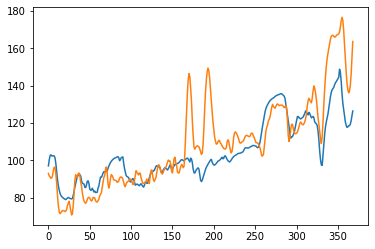

4-TS:(10.279069, 10.757911)
best val epoch: 1
[1/200]: loss_train: 20.242 loss_val 21.294 loss_ts 23.335
best val epoch: 2
[2/200]: loss_train: 19.688 loss_val 21.143 loss_ts 22.812
best val epoch: 3
[3/200]: loss_train: 19.214 loss_val 21.055 loss_ts 22.360
best val epoch: 4
[4/200]: loss_train: 18.778 loss_val 20.970 loss_ts 21.945
best val epoch: 5
[5/200]: loss_train: 18.361 loss_val 20.878 loss_ts 21.580
best val epoch: 6
[6/200]: loss_train: 17.979 loss_val 20.804 loss_ts 21.208
best val epoch: 7
[7/200]: loss_train: 17.648 loss_val 20.744 loss_ts 20.855
best val epoch: 8
[8/200]: loss_train: 17.410 loss_val 20.722 loss_ts 20.527
best val epoch: 14
[14/200]: loss_train: 16.962 loss_val 20.586 loss_ts 19.737
best val epoch: 15
[15/200]: loss_train: 16.825 loss_val 20.382 loss_ts 19.714
best val epoch: 16
[16/200]: loss_train: 16.679 loss_val 20.165 loss_ts 19.716
best val epoch: 17
[17/200]: loss_train: 16.535 loss_val 19.955 loss_ts 19.749
best val epoch: 18
[18/200]: loss_train:

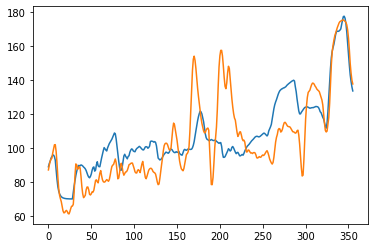

5-TS:(13.23214, 15.093841)
best val epoch: 1
[1/200]: loss_train: 19.374 loss_val 22.292 loss_ts 23.930
best val epoch: 2
[2/200]: loss_train: 18.774 loss_val 21.880 loss_ts 23.174
best val epoch: 3
[3/200]: loss_train: 18.274 loss_val 21.530 loss_ts 22.486
best val epoch: 4
[4/200]: loss_train: 17.897 loss_val 21.222 loss_ts 21.869
best val epoch: 5
[5/200]: loss_train: 17.617 loss_val 20.968 loss_ts 21.335
best val epoch: 6
[6/200]: loss_train: 17.450 loss_val 20.770 loss_ts 20.891
best val epoch: 7
[7/200]: loss_train: 17.366 loss_val 20.600 loss_ts 20.564
best val epoch: 8
[8/200]: loss_train: 17.309 loss_val 20.433 loss_ts 20.359
best val epoch: 9
[9/200]: loss_train: 17.244 loss_val 20.273 loss_ts 20.259
best val epoch: 10
[10/200]: loss_train: 17.158 loss_val 20.130 loss_ts 20.238
best val epoch: 11
[11/200]: loss_train: 17.052 loss_val 19.995 loss_ts 20.299
best val epoch: 12
[12/200]: loss_train: 16.934 loss_val 19.875 loss_ts 20.426
best val epoch: 13
[13/200]: loss_train: 16

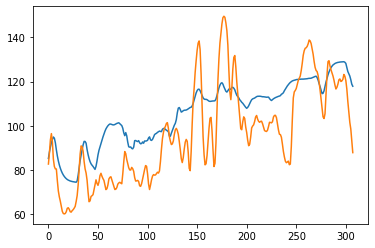

6-TS:(13.614049, 14.158181)
best val epoch: 1
[1/200]: loss_train: 22.961 loss_val 21.046 loss_ts 28.041
best val epoch: 2
[2/200]: loss_train: 22.222 loss_val 20.325 loss_ts 27.395
best val epoch: 3
[3/200]: loss_train: 21.545 loss_val 19.704 loss_ts 26.858
best val epoch: 4
[4/200]: loss_train: 20.937 loss_val 19.166 loss_ts 26.398
best val epoch: 5
[5/200]: loss_train: 20.393 loss_val 18.700 loss_ts 25.976
best val epoch: 6
[6/200]: loss_train: 19.880 loss_val 18.293 loss_ts 25.602
best val epoch: 7
[7/200]: loss_train: 19.377 loss_val 17.947 loss_ts 25.265
best val epoch: 8
[8/200]: loss_train: 18.879 loss_val 17.682 loss_ts 24.992
best val epoch: 9
[9/200]: loss_train: 18.383 loss_val 17.470 loss_ts 24.771
best val epoch: 10
[10/200]: loss_train: 17.939 loss_val 17.315 loss_ts 24.619
best val epoch: 17
[17/200]: loss_train: 16.573 loss_val 17.217 loss_ts 25.239
best val epoch: 18
[18/200]: loss_train: 16.482 loss_val 17.151 loss_ts 25.436
best val epoch: 33
[33/200]: loss_train: 1

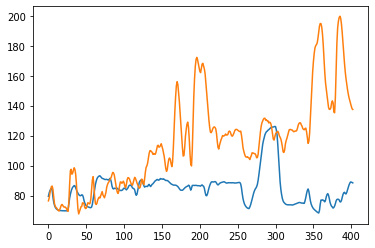

7-TS:(32.394867, 32.791607)
best val epoch: 1
[1/200]: loss_train: 20.628 loss_val 22.098 loss_ts 27.673
best val epoch: 2
[2/200]: loss_train: 19.737 loss_val 20.196 loss_ts 27.697
best val epoch: 3
[3/200]: loss_train: 19.024 loss_val 18.527 loss_ts 27.832
best val epoch: 4
[4/200]: loss_train: 18.424 loss_val 17.118 loss_ts 28.083
best val epoch: 5
[5/200]: loss_train: 17.921 loss_val 15.857 loss_ts 28.474
best val epoch: 6
[6/200]: loss_train: 17.551 loss_val 14.551 loss_ts 29.051
best val epoch: 7
[7/200]: loss_train: 17.306 loss_val 13.370 loss_ts 29.489
best val epoch: 8
[8/200]: loss_train: 17.214 loss_val 12.541 loss_ts 29.603
best val epoch: 9
[9/200]: loss_train: 17.207 loss_val 12.205 loss_ts 29.234
best val epoch: 10
[10/200]: loss_train: 17.175 loss_val 12.060 loss_ts 28.506
best val epoch: 11
[11/200]: loss_train: 17.074 loss_val 12.012 loss_ts 27.556
best val epoch: 39
[39/200]: loss_train: 13.575 loss_val 11.748 loss_ts 23.999
best val epoch: 40
[40/200]: loss_train: 1

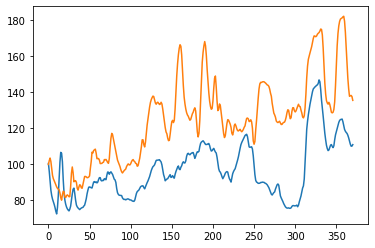

0-TS:(27.9197, 28.139103)
best val epoch: 1
[1/200]: loss_train: 20.743 loss_val 17.076 loss_ts 16.874
best val epoch: 2
[2/200]: loss_train: 20.259 loss_val 16.447 loss_ts 16.534
best val epoch: 3
[3/200]: loss_train: 19.835 loss_val 15.826 loss_ts 16.246
best val epoch: 4
[4/200]: loss_train: 19.515 loss_val 15.239 loss_ts 16.184
best val epoch: 5
[5/200]: loss_train: 19.273 loss_val 14.752 loss_ts 16.334
best val epoch: 6
[6/200]: loss_train: 19.165 loss_val 14.618 loss_ts 16.483
best val epoch: 7
[7/200]: loss_train: 19.093 loss_val 14.604 loss_ts 16.544
best val epoch: 8
[8/200]: loss_train: 18.989 loss_val 14.542 loss_ts 16.518
best val epoch: 9
[9/200]: loss_train: 18.849 loss_val 14.426 loss_ts 16.391
best val epoch: 10
[10/200]: loss_train: 18.700 loss_val 14.304 loss_ts 16.222
best val epoch: 11
[11/200]: loss_train: 18.549 loss_val 14.238 loss_ts 16.038
best val epoch: 18
[18/200]: loss_train: 17.767 loss_val 14.230 loss_ts 15.262
best val epoch: 19
[19/200]: loss_train: 17.

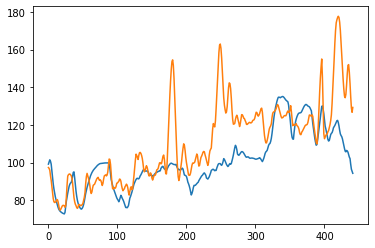

1-TS:(13.242384, 13.594974)
best val epoch: 1
[1/200]: loss_train: 21.609 loss_val 22.159 loss_ts 25.498
best val epoch: 2
[2/200]: loss_train: 20.544 loss_val 21.424 loss_ts 24.486
best val epoch: 3
[3/200]: loss_train: 19.756 loss_val 21.010 loss_ts 23.360
best val epoch: 4
[4/200]: loss_train: 19.254 loss_val 20.733 loss_ts 22.229
best val epoch: 5
[5/200]: loss_train: 18.939 loss_val 20.621 loss_ts 21.420
best val epoch: 6
[6/200]: loss_train: 18.828 loss_val 20.611 loss_ts 20.951
best val epoch: 17
[17/200]: loss_train: 17.358 loss_val 20.600 loss_ts 20.083
best val epoch: 18
[18/200]: loss_train: 17.199 loss_val 20.552 loss_ts 19.548
best val epoch: 19
[19/200]: loss_train: 17.042 loss_val 20.501 loss_ts 18.963
best val epoch: 20
[20/200]: loss_train: 16.918 loss_val 20.417 loss_ts 18.334
best val epoch: 21
[21/200]: loss_train: 16.880 loss_val 20.365 loss_ts 17.909
best val epoch: 22
[22/200]: loss_train: 16.857 loss_val 20.343 loss_ts 17.739
best val epoch: 23
[23/200]: loss_tr

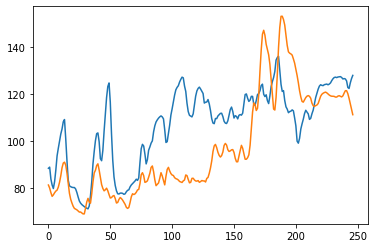

2-TS:(15.518063, 16.147942)
best val epoch: 1
[1/200]: loss_train: 22.129 loss_val 20.097 loss_ts 15.437
best val epoch: 2
[2/200]: loss_train: 21.554 loss_val 19.308 loss_ts 14.778
best val epoch: 3
[3/200]: loss_train: 21.052 loss_val 18.589 loss_ts 14.171
best val epoch: 4
[4/200]: loss_train: 20.615 loss_val 17.899 loss_ts 13.672
best val epoch: 5
[5/200]: loss_train: 20.223 loss_val 17.281 loss_ts 13.267
best val epoch: 6
[6/200]: loss_train: 19.849 loss_val 16.732 loss_ts 12.917
best val epoch: 7
[7/200]: loss_train: 19.502 loss_val 16.282 loss_ts 12.656
best val epoch: 8
[8/200]: loss_train: 19.172 loss_val 15.888 loss_ts 12.457
best val epoch: 9
[9/200]: loss_train: 18.867 loss_val 15.585 loss_ts 12.284
best val epoch: 10
[10/200]: loss_train: 18.604 loss_val 15.445 loss_ts 12.182
best val epoch: 11
[11/200]: loss_train: 18.466 loss_val 15.377 loss_ts 12.238
best val epoch: 12
[12/200]: loss_train: 18.422 loss_val 15.344 loss_ts 12.408
best val epoch: 13
[13/200]: loss_train: 1

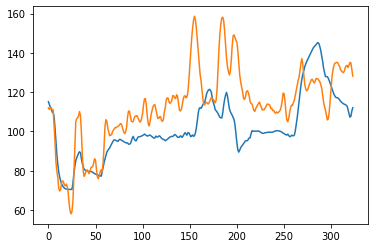

3-TS:(14.83875, 15.708885)
best val epoch: 1
[1/200]: loss_train: 19.880 loss_val 24.507 loss_ts 24.631
best val epoch: 2
[2/200]: loss_train: 19.318 loss_val 24.088 loss_ts 24.037
best val epoch: 3
[3/200]: loss_train: 18.870 loss_val 23.719 loss_ts 23.480
best val epoch: 4
[4/200]: loss_train: 18.478 loss_val 23.393 loss_ts 22.946
best val epoch: 5
[5/200]: loss_train: 18.120 loss_val 23.095 loss_ts 22.430
best val epoch: 6
[6/200]: loss_train: 17.764 loss_val 22.781 loss_ts 21.945
best val epoch: 7
[7/200]: loss_train: 17.405 loss_val 22.466 loss_ts 21.460
best val epoch: 8
[8/200]: loss_train: 17.051 loss_val 22.190 loss_ts 20.995
best val epoch: 9
[9/200]: loss_train: 16.698 loss_val 21.945 loss_ts 20.525
best val epoch: 10
[10/200]: loss_train: 16.346 loss_val 21.752 loss_ts 20.078
best val epoch: 11
[11/200]: loss_train: 16.041 loss_val 21.652 loss_ts 19.643
best val epoch: 12
[12/200]: loss_train: 15.833 loss_val 21.565 loss_ts 19.278
best val epoch: 13
[13/200]: loss_train: 15

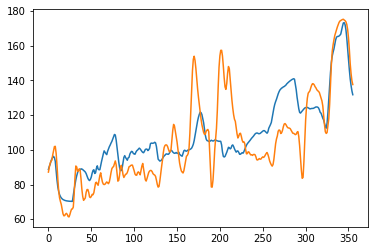

5-TS:(13.447873, 15.037063)
best val epoch: 1
[1/200]: loss_train: 18.496 loss_val 17.093 loss_ts 22.375
best val epoch: 2
[2/200]: loss_train: 18.250 loss_val 16.785 loss_ts 22.024
best val epoch: 3
[3/200]: loss_train: 18.032 loss_val 16.592 loss_ts 21.707
best val epoch: 4
[4/200]: loss_train: 17.837 loss_val 16.513 loss_ts 21.446
best val epoch: 32
[32/200]: loss_train: 14.304 loss_val 16.496 loss_ts 17.779
best val epoch: 33
[33/200]: loss_train: 13.868 loss_val 16.435 loss_ts 17.646
best val epoch: 36
[36/200]: loss_train: 13.529 loss_val 16.191 loss_ts 16.175
best val epoch: 37
[37/200]: loss_train: 14.159 loss_val 15.807 loss_ts 17.195
best val epoch: 44
[44/200]: loss_train: 13.243 loss_val 15.770 loss_ts 15.679
best val epoch: 45
[45/200]: loss_train: 13.177 loss_val 15.426 loss_ts 15.452
best val epoch: 46
[46/200]: loss_train: 13.141 loss_val 15.250 loss_ts 15.456
best val epoch: 50
[50/200]: loss_train: 12.094 loss_val 14.718 loss_ts 16.112
best val epoch: 51
[51/200]: los

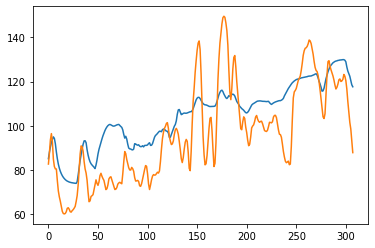

6-TS:(13.052703, 13.658864)
best val epoch: 1
[1/200]: loss_train: 19.683 loss_val 25.363 loss_ts 27.371
best val epoch: 2
[2/200]: loss_train: 18.889 loss_val 24.435 loss_ts 26.064
best val epoch: 3
[3/200]: loss_train: 18.188 loss_val 23.577 loss_ts 25.110
best val epoch: 4
[4/200]: loss_train: 17.585 loss_val 22.744 loss_ts 24.397
best val epoch: 5
[5/200]: loss_train: 17.032 loss_val 21.901 loss_ts 23.793
best val epoch: 6
[6/200]: loss_train: 16.493 loss_val 21.176 loss_ts 23.388
best val epoch: 7
[7/200]: loss_train: 16.089 loss_val 20.569 loss_ts 23.026
best val epoch: 8
[8/200]: loss_train: 15.835 loss_val 20.016 loss_ts 22.722
best val epoch: 9
[9/200]: loss_train: 15.636 loss_val 19.511 loss_ts 22.529
best val epoch: 10
[10/200]: loss_train: 15.404 loss_val 19.132 loss_ts 22.612
best val epoch: 11
[11/200]: loss_train: 15.161 loss_val 18.825 loss_ts 22.958
best val epoch: 12
[12/200]: loss_train: 15.011 loss_val 18.591 loss_ts 23.393
best val epoch: 13
[13/200]: loss_train: 1

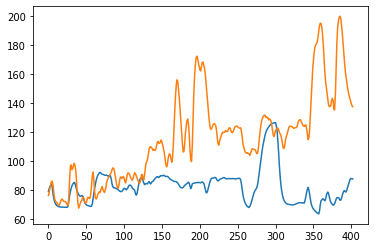

7-TS:(34.01117, 34.54565)
best val epoch: 1
[1/200]: loss_train: 22.228 loss_val 18.657 loss_ts 20.573
best val epoch: 2
[2/200]: loss_train: 21.042 loss_val 17.493 loss_ts 20.298
best val epoch: 3
[3/200]: loss_train: 20.197 loss_val 16.888 loss_ts 20.313
best val epoch: 4
[4/200]: loss_train: 19.535 loss_val 16.465 loss_ts 20.527
best val epoch: 5
[5/200]: loss_train: 18.976 loss_val 16.192 loss_ts 20.868
best val epoch: 6
[6/200]: loss_train: 18.479 loss_val 16.023 loss_ts 21.281
best val epoch: 7
[7/200]: loss_train: 18.038 loss_val 15.913 loss_ts 21.827
best val epoch: 8
[8/200]: loss_train: 17.674 loss_val 15.864 loss_ts 22.480
best val epoch: 63
[63/200]: loss_train: 11.770 loss_val 15.707 loss_ts 26.635
best val epoch: 64
[64/200]: loss_train: 11.463 loss_val 15.249 loss_ts 24.589
best val epoch: 65
[65/200]: loss_train: 11.505 loss_val 15.056 loss_ts 23.159
best val epoch: 78
[78/200]: loss_train: 10.203 loss_val 14.937 loss_ts 25.908
best val epoch: 79
[79/200]: loss_train: 1

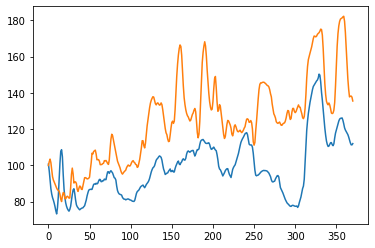

0-TS:(25.978315, 26.186556)
best val epoch: 1
[1/200]: loss_train: 18.402 loss_val 22.398 loss_ts 17.661
best val epoch: 2
[2/200]: loss_train: 18.068 loss_val 22.175 loss_ts 17.257
best val epoch: 3
[3/200]: loss_train: 17.759 loss_val 22.060 loss_ts 16.945
best val epoch: 7
[7/200]: loss_train: 17.192 loss_val 21.970 loss_ts 16.939
best val epoch: 8
[8/200]: loss_train: 17.068 loss_val 21.777 loss_ts 16.788
best val epoch: 9
[9/200]: loss_train: 16.976 loss_val 21.550 loss_ts 16.562
best val epoch: 10
[10/200]: loss_train: 16.939 loss_val 21.327 loss_ts 16.330
best val epoch: 11
[11/200]: loss_train: 16.917 loss_val 21.134 loss_ts 16.170
best val epoch: 12
[12/200]: loss_train: 16.854 loss_val 21.006 loss_ts 16.081
best val epoch: 13
[13/200]: loss_train: 16.761 loss_val 20.915 loss_ts 16.017
best val epoch: 14
[14/200]: loss_train: 16.625 loss_val 20.861 loss_ts 15.961
best val epoch: 15
[15/200]: loss_train: 16.470 loss_val 20.832 loss_ts 15.941
best val epoch: 16
[16/200]: loss_tr

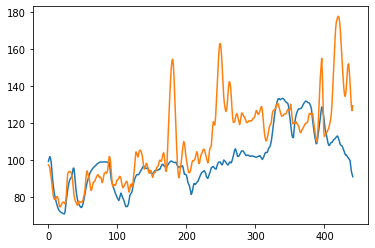

1-TS:(14.04041, 14.443448)
best val epoch: 35
[35/200]: loss_train: 17.154 loss_val 19.173 loss_ts 17.648
best val epoch: 36
[36/200]: loss_train: 17.163 loss_val 19.053 loss_ts 17.741
best val epoch: 37
[37/200]: loss_train: 17.186 loss_val 18.940 loss_ts 17.794
best val epoch: 51
[51/200]: loss_train: 16.973 loss_val 18.588 loss_ts 17.743
best val epoch: 52
[52/200]: loss_train: 17.246 loss_val 18.195 loss_ts 18.434
best val epoch: 53
[53/200]: loss_train: 17.451 loss_val 17.904 loss_ts 18.885
best val epoch: 54
[54/200]: loss_train: 17.615 loss_val 17.781 loss_ts 19.113
best val epoch: 57
[57/200]: loss_train: 17.507 loss_val 17.617 loss_ts 18.759
best val epoch: 58
[58/200]: loss_train: 17.452 loss_val 17.567 loss_ts 18.551
best val epoch: 60
[60/200]: loss_train: 17.297 loss_val 17.529 loss_ts 18.228
best val epoch: 61
[61/200]: loss_train: 17.242 loss_val 17.475 loss_ts 18.246
best val epoch: 62
[62/200]: loss_train: 17.209 loss_val 17.423 loss_ts 18.378
best val epoch: 72
[72/20

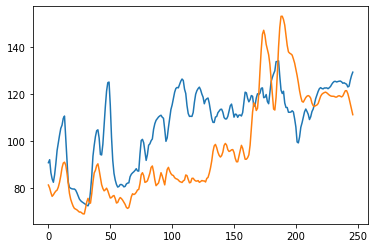

2-TS:(16.220097, 16.844652)
best val epoch: 1
[1/200]: loss_train: 23.408 loss_val 20.644 loss_ts 18.179
best val epoch: 2
[2/200]: loss_train: 22.730 loss_val 19.913 loss_ts 17.191
best val epoch: 3
[3/200]: loss_train: 22.156 loss_val 19.339 loss_ts 16.365
best val epoch: 4
[4/200]: loss_train: 21.682 loss_val 18.885 loss_ts 15.653
best val epoch: 5
[5/200]: loss_train: 21.285 loss_val 18.487 loss_ts 15.025
best val epoch: 6
[6/200]: loss_train: 20.914 loss_val 18.138 loss_ts 14.459
best val epoch: 7
[7/200]: loss_train: 20.565 loss_val 17.820 loss_ts 13.967
best val epoch: 8
[8/200]: loss_train: 20.215 loss_val 17.549 loss_ts 13.528
best val epoch: 9
[9/200]: loss_train: 19.892 loss_val 17.315 loss_ts 13.164
best val epoch: 10
[10/200]: loss_train: 19.583 loss_val 17.109 loss_ts 12.868
best val epoch: 11
[11/200]: loss_train: 19.290 loss_val 16.989 loss_ts 12.608
best val epoch: 35
[35/200]: loss_train: 16.111 loss_val 16.862 loss_ts 12.657
best val epoch: 36
[36/200]: loss_train: 1

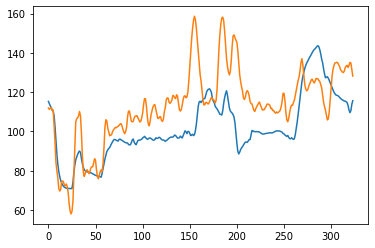

3-TS:(14.792444, 15.554746)
best val epoch: 1
[1/200]: loss_train: 22.781 loss_val 24.734 loss_ts 22.537
best val epoch: 2
[2/200]: loss_train: 21.919 loss_val 23.757 loss_ts 22.087
best val epoch: 3
[3/200]: loss_train: 21.279 loss_val 22.940 loss_ts 21.719
best val epoch: 4
[4/200]: loss_train: 20.869 loss_val 22.260 loss_ts 21.391
best val epoch: 5
[5/200]: loss_train: 20.586 loss_val 21.709 loss_ts 21.118
best val epoch: 6
[6/200]: loss_train: 20.350 loss_val 21.267 loss_ts 20.871
best val epoch: 7
[7/200]: loss_train: 20.127 loss_val 20.910 loss_ts 20.659
best val epoch: 8
[8/200]: loss_train: 19.923 loss_val 20.620 loss_ts 20.481
best val epoch: 9
[9/200]: loss_train: 19.735 loss_val 20.380 loss_ts 20.334
best val epoch: 10
[10/200]: loss_train: 19.550 loss_val 20.180 loss_ts 20.209
best val epoch: 11
[11/200]: loss_train: 19.369 loss_val 20.028 loss_ts 20.096
best val epoch: 12
[12/200]: loss_train: 19.186 loss_val 19.928 loss_ts 19.983
best val epoch: 13
[13/200]: loss_train: 1

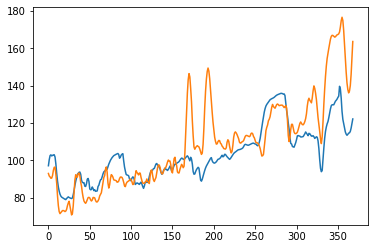

4-TS:(11.401329, 12.200735)
best val epoch: 1
[1/200]: loss_train: 21.413 loss_val 29.233 loss_ts 20.649
best val epoch: 2
[2/200]: loss_train: 20.779 loss_val 28.658 loss_ts 20.658
best val epoch: 3
[3/200]: loss_train: 20.232 loss_val 28.131 loss_ts 20.765
best val epoch: 4
[4/200]: loss_train: 19.756 loss_val 27.648 loss_ts 20.968
best val epoch: 5
[5/200]: loss_train: 19.347 loss_val 27.193 loss_ts 21.215
best val epoch: 6
[6/200]: loss_train: 18.976 loss_val 26.777 loss_ts 21.476
best val epoch: 7
[7/200]: loss_train: 18.633 loss_val 26.379 loss_ts 21.682
best val epoch: 8
[8/200]: loss_train: 18.326 loss_val 26.018 loss_ts 21.845
best val epoch: 9
[9/200]: loss_train: 18.041 loss_val 25.679 loss_ts 21.983
best val epoch: 10
[10/200]: loss_train: 17.776 loss_val 25.368 loss_ts 22.090
best val epoch: 11
[11/200]: loss_train: 17.536 loss_val 25.079 loss_ts 22.157
best val epoch: 12
[12/200]: loss_train: 17.326 loss_val 24.831 loss_ts 22.191
best val epoch: 13
[13/200]: loss_train: 1

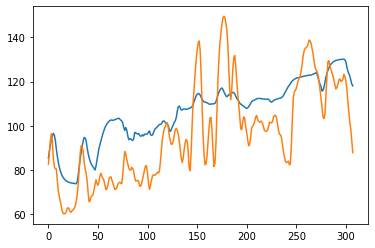

6-TS:(14.124594, 14.731633)
best val epoch: 1
[1/200]: loss_train: 19.701 loss_val 16.035 loss_ts 26.194
best val epoch: 2
[2/200]: loss_train: 19.196 loss_val 15.958 loss_ts 26.223
best val epoch: 3
[3/200]: loss_train: 18.735 loss_val 15.928 loss_ts 26.275
best val epoch: 14
[14/200]: loss_train: 16.740 loss_val 15.828 loss_ts 28.573
best val epoch: 15
[15/200]: loss_train: 16.581 loss_val 15.568 loss_ts 28.386
best val epoch: 16
[16/200]: loss_train: 16.424 loss_val 15.358 loss_ts 28.217
best val epoch: 17
[17/200]: loss_train: 16.265 loss_val 15.168 loss_ts 28.060
best val epoch: 18
[18/200]: loss_train: 16.094 loss_val 14.999 loss_ts 28.009
best val epoch: 19
[19/200]: loss_train: 15.910 loss_val 14.859 loss_ts 28.015
best val epoch: 20
[20/200]: loss_train: 15.699 loss_val 14.753 loss_ts 27.997
best val epoch: 21
[21/200]: loss_train: 15.452 loss_val 14.635 loss_ts 27.982
best val epoch: 22
[22/200]: loss_train: 15.182 loss_val 14.506 loss_ts 28.026
best val epoch: 23
[23/200]: l

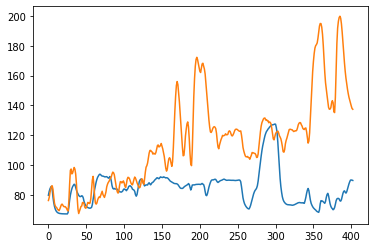

7-TS:(32.306934, 33.149155)
best val epoch: 1
[1/200]: loss_train: 19.935 loss_val 18.475 loss_ts 23.379
best val epoch: 2
[2/200]: loss_train: 19.474 loss_val 18.091 loss_ts 23.143
best val epoch: 3
[3/200]: loss_train: 19.034 loss_val 17.760 loss_ts 23.000
best val epoch: 4
[4/200]: loss_train: 18.616 loss_val 17.475 loss_ts 22.981
best val epoch: 5
[5/200]: loss_train: 18.221 loss_val 17.219 loss_ts 23.042
best val epoch: 6
[6/200]: loss_train: 17.857 loss_val 17.029 loss_ts 23.263
best val epoch: 7
[7/200]: loss_train: 17.500 loss_val 16.869 loss_ts 23.793
best val epoch: 8
[8/200]: loss_train: 17.185 loss_val 16.715 loss_ts 24.710
best val epoch: 9
[9/200]: loss_train: 16.965 loss_val 16.654 loss_ts 25.928
best val epoch: 15
[15/200]: loss_train: 16.681 loss_val 16.646 loss_ts 29.412
best val epoch: 16
[16/200]: loss_train: 16.520 loss_val 16.432 loss_ts 28.771
best val epoch: 17
[17/200]: loss_train: 16.394 loss_val 16.229 loss_ts 28.026
best val epoch: 18
[18/200]: loss_train: 1

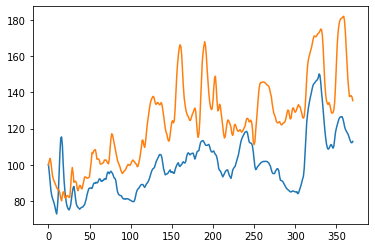

0-TS:(25.50789, 25.703146)
best val epoch: 1
[1/200]: loss_train: 20.987 loss_val 20.218 loss_ts 17.872
best val epoch: 2
[2/200]: loss_train: 20.633 loss_val 19.804 loss_ts 17.667
best val epoch: 3
[3/200]: loss_train: 20.328 loss_val 19.409 loss_ts 17.460
best val epoch: 4
[4/200]: loss_train: 20.054 loss_val 19.063 loss_ts 17.258
best val epoch: 5
[5/200]: loss_train: 19.804 loss_val 18.729 loss_ts 17.061
best val epoch: 6
[6/200]: loss_train: 19.569 loss_val 18.392 loss_ts 16.845
best val epoch: 7
[7/200]: loss_train: 19.345 loss_val 18.066 loss_ts 16.615
best val epoch: 8
[8/200]: loss_train: 19.130 loss_val 17.758 loss_ts 16.398
best val epoch: 9
[9/200]: loss_train: 18.925 loss_val 17.481 loss_ts 16.183
best val epoch: 10
[10/200]: loss_train: 18.728 loss_val 17.212 loss_ts 15.985
best val epoch: 11
[11/200]: loss_train: 18.549 loss_val 16.956 loss_ts 15.799
best val epoch: 12
[12/200]: loss_train: 18.377 loss_val 16.737 loss_ts 15.686
best val epoch: 13
[13/200]: loss_train: 18

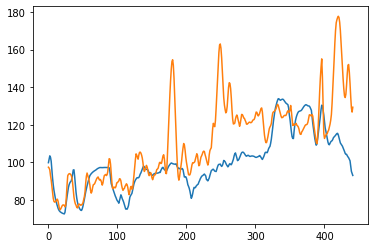

1-TS:(13.690797, 14.184721)
best val epoch: 1
[1/200]: loss_train: 21.300 loss_val 19.973 loss_ts 23.610
best val epoch: 2
[2/200]: loss_train: 20.551 loss_val 18.372 loss_ts 22.590
best val epoch: 3
[3/200]: loss_train: 20.071 loss_val 17.081 loss_ts 21.642
best val epoch: 4
[4/200]: loss_train: 19.759 loss_val 16.226 loss_ts 20.873
best val epoch: 5
[5/200]: loss_train: 19.638 loss_val 15.841 loss_ts 20.391
best val epoch: 6
[6/200]: loss_train: 19.591 loss_val 15.685 loss_ts 20.090
best val epoch: 7
[7/200]: loss_train: 19.548 loss_val 15.531 loss_ts 19.777
best val epoch: 8
[8/200]: loss_train: 19.455 loss_val 15.334 loss_ts 19.469
best val epoch: 9
[9/200]: loss_train: 19.333 loss_val 14.990 loss_ts 18.963
best val epoch: 10
[10/200]: loss_train: 19.227 loss_val 14.746 loss_ts 18.512
best val epoch: 37
[37/200]: loss_train: 17.064 loss_val 14.713 loss_ts 19.448
best val epoch: 38
[38/200]: loss_train: 16.809 loss_val 14.659 loss_ts 19.246
best val epoch: 39
[39/200]: loss_train: 1

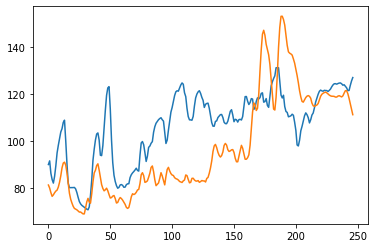

2-TS:(15.53583, 16.24915)
best val epoch: 1
[1/200]: loss_train: 22.889 loss_val 17.664 loss_ts 15.768
best val epoch: 2
[2/200]: loss_train: 22.170 loss_val 17.384 loss_ts 15.072
best val epoch: 3
[3/200]: loss_train: 21.565 loss_val 17.262 loss_ts 14.416
best val epoch: 4
[4/200]: loss_train: 21.085 loss_val 17.233 loss_ts 13.865
best val epoch: 19
[19/200]: loss_train: 18.439 loss_val 17.129 loss_ts 11.699
best val epoch: 20
[20/200]: loss_train: 18.360 loss_val 17.031 loss_ts 11.705
best val epoch: 21
[21/200]: loss_train: 18.290 loss_val 16.937 loss_ts 11.745
best val epoch: 22
[22/200]: loss_train: 18.225 loss_val 16.851 loss_ts 11.795
best val epoch: 23
[23/200]: loss_train: 18.154 loss_val 16.763 loss_ts 11.846
best val epoch: 24
[24/200]: loss_train: 18.074 loss_val 16.685 loss_ts 11.897
best val epoch: 25
[25/200]: loss_train: 17.979 loss_val 16.610 loss_ts 11.942
best val epoch: 26
[26/200]: loss_train: 17.868 loss_val 16.535 loss_ts 11.976
best val epoch: 27
[27/200]: loss_

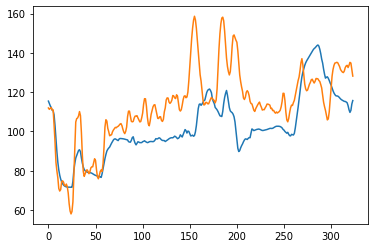

3-TS:(14.498009, 15.25825)
best val epoch: 1
[1/200]: loss_train: 20.964 loss_val 21.565 loss_ts 18.830
best val epoch: 2
[2/200]: loss_train: 20.618 loss_val 21.382 loss_ts 18.699
best val epoch: 3
[3/200]: loss_train: 20.283 loss_val 21.187 loss_ts 18.575
best val epoch: 4
[4/200]: loss_train: 19.960 loss_val 21.034 loss_ts 18.466
best val epoch: 5
[5/200]: loss_train: 19.641 loss_val 20.835 loss_ts 18.359
best val epoch: 6
[6/200]: loss_train: 19.325 loss_val 20.603 loss_ts 18.263
best val epoch: 7
[7/200]: loss_train: 19.011 loss_val 20.352 loss_ts 18.169
best val epoch: 8
[8/200]: loss_train: 18.690 loss_val 20.054 loss_ts 18.067
best val epoch: 9
[9/200]: loss_train: 18.362 loss_val 19.719 loss_ts 17.956
best val epoch: 10
[10/200]: loss_train: 18.030 loss_val 19.362 loss_ts 17.838
best val epoch: 11
[11/200]: loss_train: 17.717 loss_val 19.028 loss_ts 17.715
best val epoch: 12
[12/200]: loss_train: 17.420 loss_val 18.720 loss_ts 17.592
best val epoch: 13
[13/200]: loss_train: 17

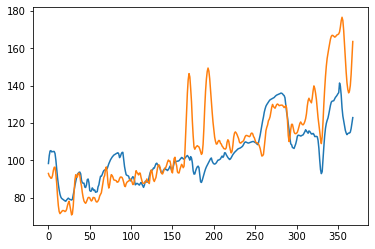

4-TS:(11.247497, 12.001428)
best val epoch: 1
[1/200]: loss_train: 21.824 loss_val 22.101 loss_ts 23.322
best val epoch: 2
[2/200]: loss_train: 21.118 loss_val 22.021 loss_ts 22.681
best val epoch: 13
[13/200]: loss_train: 17.702 loss_val 21.900 loss_ts 19.132
best val epoch: 14
[14/200]: loss_train: 17.599 loss_val 21.609 loss_ts 19.020
best val epoch: 15
[15/200]: loss_train: 17.445 loss_val 21.292 loss_ts 18.950
best val epoch: 16
[16/200]: loss_train: 17.272 loss_val 20.962 loss_ts 18.919
best val epoch: 17
[17/200]: loss_train: 17.114 loss_val 20.627 loss_ts 18.946
best val epoch: 18
[18/200]: loss_train: 17.000 loss_val 20.307 loss_ts 19.036
best val epoch: 19
[19/200]: loss_train: 16.916 loss_val 19.996 loss_ts 19.150
best val epoch: 20
[20/200]: loss_train: 16.837 loss_val 19.706 loss_ts 19.279
best val epoch: 21
[21/200]: loss_train: 16.764 loss_val 19.449 loss_ts 19.400
best val epoch: 22
[22/200]: loss_train: 16.682 loss_val 19.221 loss_ts 19.503
best val epoch: 23
[23/200]:

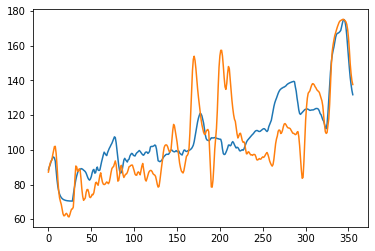

5-TS:(13.120519, 14.58266)
best val epoch: 1
[1/200]: loss_train: 21.415 loss_val 19.064 loss_ts 27.977
best val epoch: 2
[2/200]: loss_train: 20.833 loss_val 18.272 loss_ts 26.702
best val epoch: 3
[3/200]: loss_train: 20.319 loss_val 17.723 loss_ts 25.592
best val epoch: 4
[4/200]: loss_train: 19.866 loss_val 17.292 loss_ts 24.715
best val epoch: 5
[5/200]: loss_train: 19.466 loss_val 16.923 loss_ts 23.984
best val epoch: 6
[6/200]: loss_train: 19.122 loss_val 16.642 loss_ts 23.374
best val epoch: 7
[7/200]: loss_train: 18.819 loss_val 16.447 loss_ts 22.915
best val epoch: 8
[8/200]: loss_train: 18.562 loss_val 16.314 loss_ts 22.724
best val epoch: 9
[9/200]: loss_train: 18.348 loss_val 16.222 loss_ts 22.642
best val epoch: 10
[10/200]: loss_train: 18.179 loss_val 16.147 loss_ts 22.654
best val epoch: 11
[11/200]: loss_train: 18.035 loss_val 16.089 loss_ts 22.758
best val epoch: 12
[12/200]: loss_train: 17.913 loss_val 16.038 loss_ts 22.956
best val epoch: 13
[13/200]: loss_train: 17

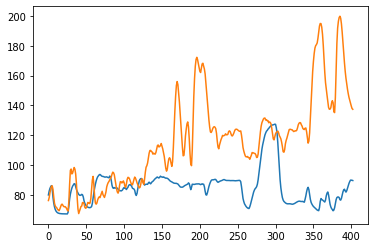

7-TS:(32.007744, 32.756973)
best val epoch: 1
[1/200]: loss_train: 19.012 loss_val 17.287 loss_ts 21.811
best val epoch: 2
[2/200]: loss_train: 18.332 loss_val 16.934 loss_ts 22.398
best val epoch: 3
[3/200]: loss_train: 17.806 loss_val 16.674 loss_ts 23.514
best val epoch: 4
[4/200]: loss_train: 17.571 loss_val 16.429 loss_ts 24.966
best val epoch: 5
[5/200]: loss_train: 17.505 loss_val 16.208 loss_ts 26.264
best val epoch: 6
[6/200]: loss_train: 17.423 loss_val 16.020 loss_ts 27.234
best val epoch: 7
[7/200]: loss_train: 17.287 loss_val 15.853 loss_ts 27.839
best val epoch: 8
[8/200]: loss_train: 17.145 loss_val 15.679 loss_ts 28.105
best val epoch: 9
[9/200]: loss_train: 17.049 loss_val 15.511 loss_ts 28.206
best val epoch: 10
[10/200]: loss_train: 16.972 loss_val 15.353 loss_ts 28.201
best val epoch: 11
[11/200]: loss_train: 16.907 loss_val 15.202 loss_ts 28.164
best val epoch: 12
[12/200]: loss_train: 16.840 loss_val 15.070 loss_ts 28.208
best val epoch: 13
[13/200]: loss_train: 1

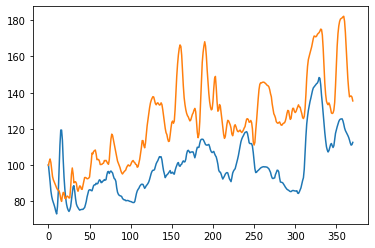

0-TS:(25.960485, 26.151579)
best val epoch: 1
[1/200]: loss_train: 20.720 loss_val 20.774 loss_ts 18.443
best val epoch: 2
[2/200]: loss_train: 20.164 loss_val 20.594 loss_ts 18.013
best val epoch: 3
[3/200]: loss_train: 19.630 loss_val 20.456 loss_ts 17.578
best val epoch: 4
[4/200]: loss_train: 19.131 loss_val 20.346 loss_ts 17.127
best val epoch: 5
[5/200]: loss_train: 18.684 loss_val 20.246 loss_ts 16.691
best val epoch: 6
[6/200]: loss_train: 18.312 loss_val 20.145 loss_ts 16.280
best val epoch: 7
[7/200]: loss_train: 18.068 loss_val 20.048 loss_ts 15.934
best val epoch: 8
[8/200]: loss_train: 17.963 loss_val 19.920 loss_ts 15.974
best val epoch: 9
[9/200]: loss_train: 17.935 loss_val 19.765 loss_ts 16.157
best val epoch: 10
[10/200]: loss_train: 17.894 loss_val 19.602 loss_ts 16.269
best val epoch: 11
[11/200]: loss_train: 17.784 loss_val 19.417 loss_ts 16.250
best val epoch: 12
[12/200]: loss_train: 17.613 loss_val 19.222 loss_ts 16.102
best val epoch: 13
[13/200]: loss_train: 1

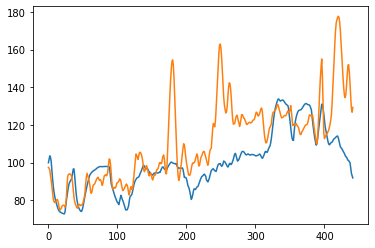

1-TS:(13.7621765, 14.216846)
best val epoch: 31
[31/200]: loss_train: 15.458 loss_val 17.932 loss_ts 16.437
best val epoch: 56
[56/200]: loss_train: 14.839 loss_val 17.714 loss_ts 16.673
best val epoch: 57
[57/200]: loss_train: 14.878 loss_val 17.473 loss_ts 17.110
best val epoch: 58
[58/200]: loss_train: 14.883 loss_val 17.436 loss_ts 17.403
best val epoch: 66
[66/200]: loss_train: 14.586 loss_val 17.097 loss_ts 17.434
best val epoch: 67
[67/200]: loss_train: 14.758 loss_val 16.435 loss_ts 17.486
best val epoch: 68
[68/200]: loss_train: 14.949 loss_val 16.233 loss_ts 17.564
best val epoch: 69
[69/200]: loss_train: 14.913 loss_val 16.134 loss_ts 17.822
best val epoch: 88
[88/200]: loss_train: 15.469 loss_val 15.967 loss_ts 17.654
best val epoch: 89
[89/200]: loss_train: 15.352 loss_val 15.801 loss_ts 17.357
best val epoch: 90
[90/200]: loss_train: 15.074 loss_val 15.631 loss_ts 16.402
best val epoch: 107
[107/200]: loss_train: 14.399 loss_val 15.620 loss_ts 18.823
best val epoch: 108
[

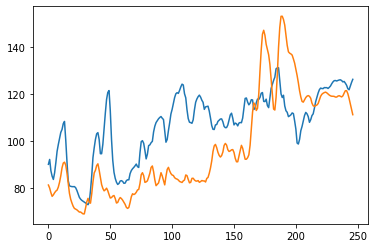

2-TS:(15.570099, 16.236273)
best val epoch: 1
[1/200]: loss_train: 20.581 loss_val 20.134 loss_ts 14.646
best val epoch: 2
[2/200]: loss_train: 20.060 loss_val 19.750 loss_ts 13.701
best val epoch: 3
[3/200]: loss_train: 19.585 loss_val 19.369 loss_ts 12.787
best val epoch: 4
[4/200]: loss_train: 19.215 loss_val 19.065 loss_ts 11.986
best val epoch: 5
[5/200]: loss_train: 19.026 loss_val 18.738 loss_ts 11.489
best val epoch: 6
[6/200]: loss_train: 18.907 loss_val 18.423 loss_ts 11.322
best val epoch: 7
[7/200]: loss_train: 18.812 loss_val 18.146 loss_ts 11.261
best val epoch: 8
[8/200]: loss_train: 18.712 loss_val 17.881 loss_ts 11.156
best val epoch: 9
[9/200]: loss_train: 18.592 loss_val 17.689 loss_ts 11.022
best val epoch: 10
[10/200]: loss_train: 18.445 loss_val 17.490 loss_ts 10.849
best val epoch: 11
[11/200]: loss_train: 18.286 loss_val 17.344 loss_ts 10.678
best val epoch: 12
[12/200]: loss_train: 18.129 loss_val 17.259 loss_ts 10.582
best val epoch: 13
[13/200]: loss_train: 1

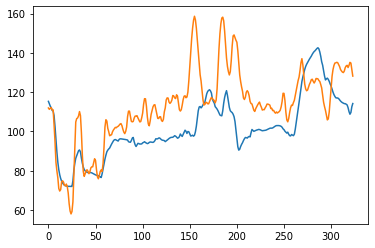

3-TS:(14.515558, 15.20741)
best val epoch: 1
[1/200]: loss_train: 18.460 loss_val 15.463 loss_ts 19.327
best val epoch: 2
[2/200]: loss_train: 17.992 loss_val 14.748 loss_ts 18.890
best val epoch: 3
[3/200]: loss_train: 17.605 loss_val 14.247 loss_ts 18.549
best val epoch: 4
[4/200]: loss_train: 17.292 loss_val 14.104 loss_ts 18.294
best val epoch: 14
[14/200]: loss_train: 15.095 loss_val 13.971 loss_ts 17.076
best val epoch: 32
[32/200]: loss_train: 12.518 loss_val 13.749 loss_ts 16.258
best val epoch: 33
[33/200]: loss_train: 12.412 loss_val 13.214 loss_ts 16.305
best val epoch: 34
[34/200]: loss_train: 12.111 loss_val 12.941 loss_ts 15.977
best val epoch: 46
[46/200]: loss_train: 11.056 loss_val 12.857 loss_ts 15.635
best val epoch: 47
[47/200]: loss_train: 11.078 loss_val 12.478 loss_ts 13.879
best val epoch: 48
[48/200]: loss_train: 11.260 loss_val 12.018 loss_ts 13.556
best val epoch: 49
[49/200]: loss_train: 11.232 loss_val 11.909 loss_ts 13.281
best val epoch: 50
[50/200]: loss

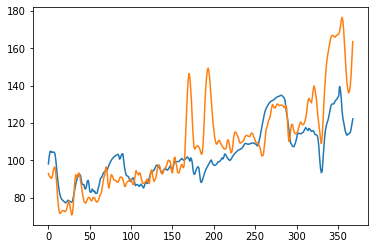

4-TS:(11.14555, 11.94155)
best val epoch: 1
[1/200]: loss_train: 18.755 loss_val 19.457 loss_ts 21.469
best val epoch: 2
[2/200]: loss_train: 18.539 loss_val 19.180 loss_ts 21.360
best val epoch: 3
[3/200]: loss_train: 18.336 loss_val 18.967 loss_ts 21.187
best val epoch: 4
[4/200]: loss_train: 18.148 loss_val 18.763 loss_ts 20.973
best val epoch: 5
[5/200]: loss_train: 17.963 loss_val 18.560 loss_ts 20.727
best val epoch: 6
[6/200]: loss_train: 17.776 loss_val 18.365 loss_ts 20.440
best val epoch: 7
[7/200]: loss_train: 17.617 loss_val 18.175 loss_ts 20.140
best val epoch: 8
[8/200]: loss_train: 17.471 loss_val 17.995 loss_ts 19.854
best val epoch: 9
[9/200]: loss_train: 17.348 loss_val 17.807 loss_ts 19.575
best val epoch: 10
[10/200]: loss_train: 17.243 loss_val 17.633 loss_ts 19.382
best val epoch: 11
[11/200]: loss_train: 17.142 loss_val 17.471 loss_ts 19.248
best val epoch: 12
[12/200]: loss_train: 17.028 loss_val 17.327 loss_ts 19.190
best val epoch: 13
[13/200]: loss_train: 16.

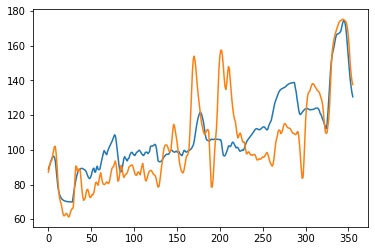

5-TS:(13.291117, 14.561904)
best val epoch: 1
[1/200]: loss_train: 21.323 loss_val 19.022 loss_ts 24.525
best val epoch: 2
[2/200]: loss_train: 20.471 loss_val 18.497 loss_ts 24.269
best val epoch: 3
[3/200]: loss_train: 19.828 loss_val 18.110 loss_ts 24.291
best val epoch: 4
[4/200]: loss_train: 19.360 loss_val 17.840 loss_ts 24.401
best val epoch: 5
[5/200]: loss_train: 19.022 loss_val 17.675 loss_ts 24.391
best val epoch: 6
[6/200]: loss_train: 18.698 loss_val 17.520 loss_ts 24.131
best val epoch: 7
[7/200]: loss_train: 18.350 loss_val 17.415 loss_ts 23.677
best val epoch: 8
[8/200]: loss_train: 17.993 loss_val 17.323 loss_ts 23.104
best val epoch: 9
[9/200]: loss_train: 17.649 loss_val 17.229 loss_ts 22.447
best val epoch: 10
[10/200]: loss_train: 17.357 loss_val 17.176 loss_ts 21.771
best val epoch: 11
[11/200]: loss_train: 17.180 loss_val 17.174 loss_ts 21.100
best val epoch: 19
[19/200]: loss_train: 16.589 loss_val 17.062 loss_ts 19.001
best val epoch: 20
[20/200]: loss_train: 1

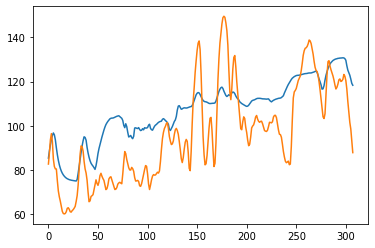

6-TS:(14.66343, 15.217188)
CPU times: user 15min 26s, sys: 16.8 s, total: 15min 43s
Wall time: 15min 46s


In [72]:
%%time
fchoice = {
    'layer_sizes': (16, 16, 16),
    'skip_mapping': ((0, 2), (0, 3), (1, 3)),
    'dropout_rate': 0.1,
    'input_features': 7,
    'period_s': 30,
    'step_s': 10,
    'ts_per_sample': 30,
    'ts_sub': 5,
    'batch_size': 64,
    'weight_decay': 1e-05,
    'lr': 0.005
}


from PPG import UtilitiesDataXY
from collections import defaultdict
nepoch = 200
aresults = defaultdict(dict)
for val_sub in range(8):#[4,5,3,2,1,0,6,7]:
  for ts_sub in range(8):
    if val_sub == ts_sub:
      continue
    fchoice["ts_sub"] = ts_sub
    # fchoice["val_sub"] = val_sub
    filename = f"pamap_ts_ffnn_{ts_sub}_val_{val_sub}_nepoch_{nepoch}_period_{fchoice['period_s']}_step_{fchoice['step_s']}.pkl"
    save_path = os.path.join(STORE_DIR, filename)
    try:
      # raise FileNotFoundError
      with open(save_path , "rb") as f:
        out = pickle.load(f)
    except FileNotFoundError:
      full_trainer = RegressionHR.FullTrainer.IteractiveFFNNFullTrainerJointValidation(dfs_train, args["device"], nepoch)
      try:
        out = full_trainer.train(**fchoice)
        with open(save_path, "wb") as f:
          pickle.dump(out, f)

      except RuntimeError as e:
        if isinstance(e, KeyboardInterrupt):
          raise e
        else:
          print("####")
          print(f"Failed: {choice}")
          print("###")
    
    print(out["args"], out["metric"])
    aresults[ts_sub][val_sub] = out
    print(f"{ts_sub}-TS:{compute_ensemble(list(aresults[ts_sub].values()))}")
    #raise Exception
    



In [64]:

df = dfs_train[0]
step_s = 2
frequency_hz = full_trainer.frequency_hz

ts_per_sample = int(len(df)/(frequency_hz*step_s))-15
transformer = RegressionHR.Preprocessing.FFNNPreprocessingTransformerGetter(
                [
            'heart_rate', 
            'h_xacc16', 'h_yacc16', 'h_zacc16',
            'h_xacc6', 'h_yacc6', 'h_zacc6'], "pamap2")(ts_per_sample=ts_per_sample, frequency_hz=full_trainer.frequency_hz, period_s=30, step_s=2, sample_step_ratio=1, ts_per_is = 1)


ts_per_sample, len(df)/(100*2)

xi,yi,xr,yr = transformer.transform(df)

yr.shape
# xi.shape

(1, 1866)

In [44]:
full_trainer.frequency_hz

100

{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 0, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 22.328491


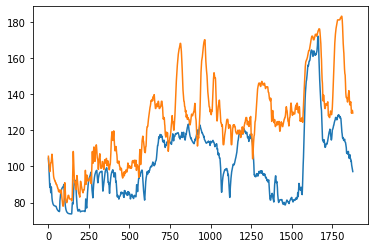

0-TS:(22.328491, 22.328491)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 1, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 11.652277


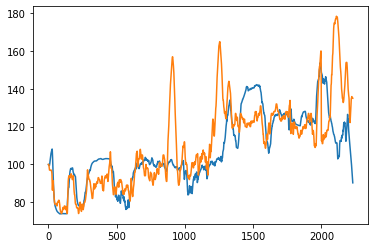

1-TS:(11.652277, 11.652277)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 2, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 11.940713


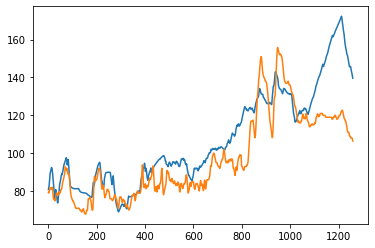

2-TS:(11.940713, 11.940713)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 3, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 24.450378


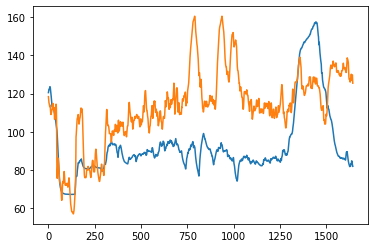

3-TS:(24.450378, 24.450378)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 5, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 15.192866


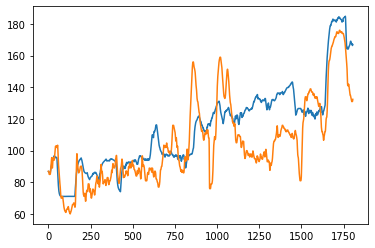

5-TS:(15.192866, 15.192866)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 6, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 28.114685


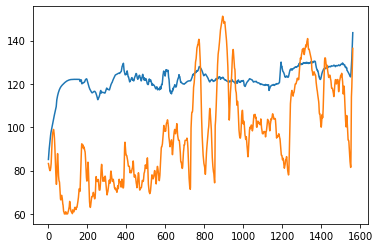

6-TS:(28.114685, 28.114685)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 7, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 36.478


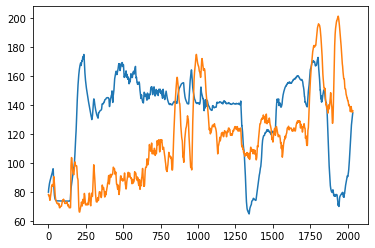

7-TS:(36.478, 36.478)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 0, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 19.600372


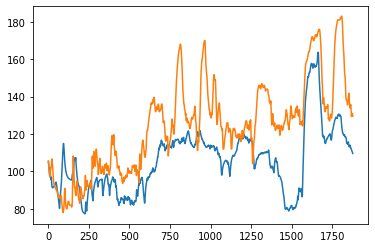

0-TS:(20.22449, 20.964432)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 1, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 13.790299


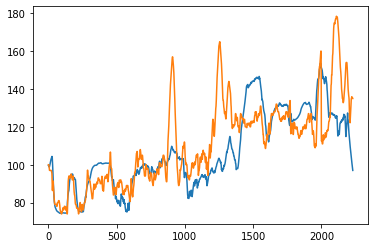

1-TS:(12.263023, 12.721289)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 2, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 14.18932


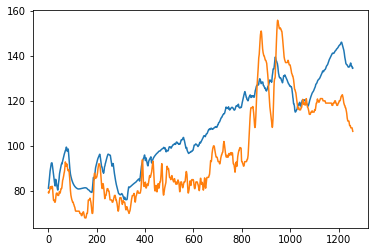

2-TS:(12.815308, 13.065018)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 3, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 19.272476


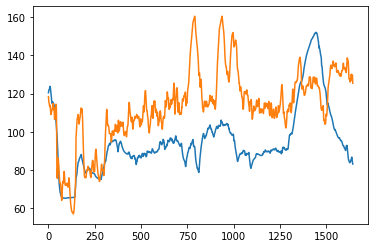

3-TS:(21.641693, 21.861427)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 4, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 22.566422


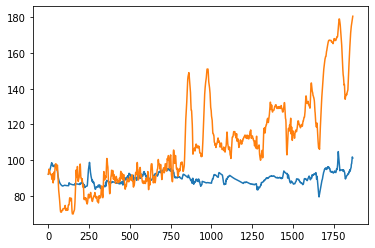

4-TS:(22.566422, 22.566422)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 6, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 19.250372


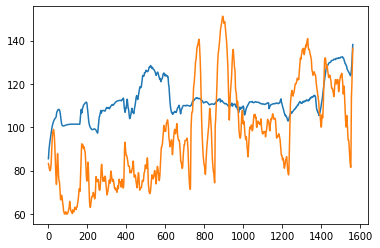

6-TS:(22.509808, 23.68253)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 7, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 35.270714


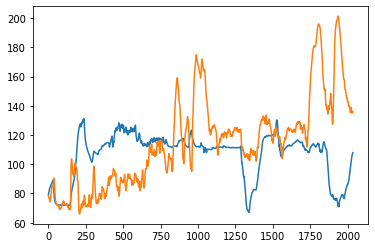

7-TS:(26.410572, 35.87436)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 0, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 22.545408


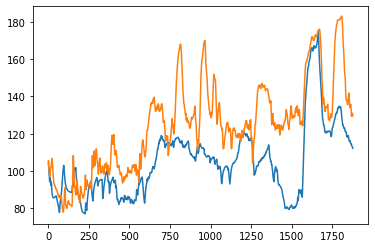

0-TS:(20.299917, 21.491423)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 1, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 10.981092


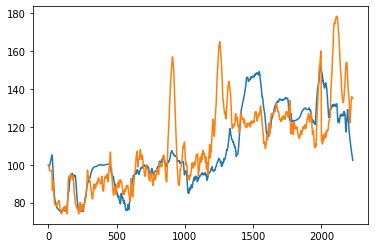

1-TS:(11.555117, 12.141223)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 2, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 7.8910775


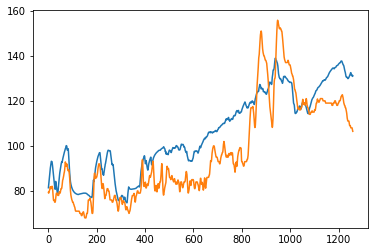

2-TS:(10.951201, 11.340372)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 4, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 22.976892


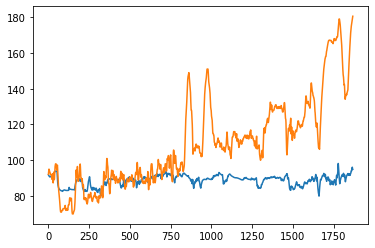

4-TS:(22.557508, 22.771656)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 5, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 19.484365


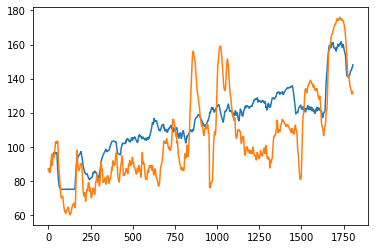

5-TS:(15.767826, 17.338615)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 6, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 15.437254


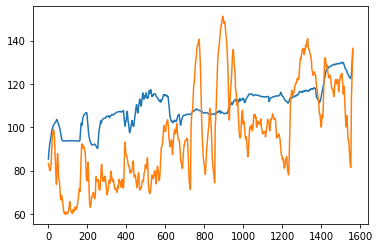

6-TS:(19.719555, 20.934105)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 7, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 33.58521


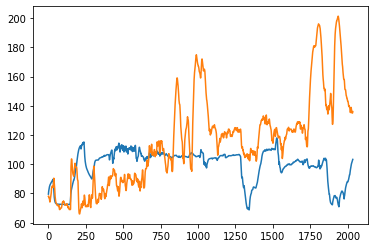

7-TS:(27.177048, 35.11131)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 0, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 20.353592


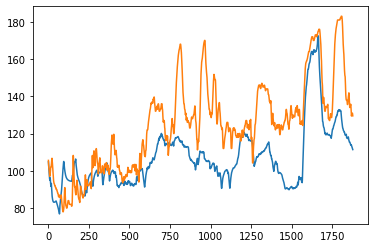

0-TS:(18.882347, 21.206964)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 1, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 24.542439


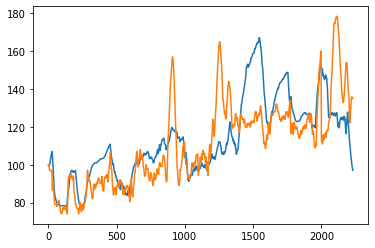

1-TS:(13.026209, 15.241528)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 3, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 17.943024


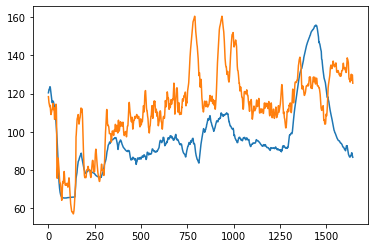

3-TS:(20.316704, 20.555292)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 4, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 14.003348


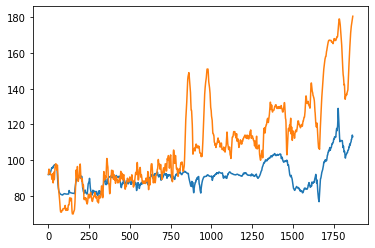

4-TS:(19.402788, 19.848888)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 5, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 15.351413


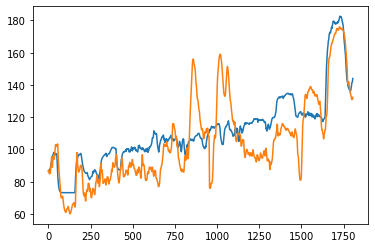

5-TS:(14.015188, 16.676214)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 6, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 14.382725


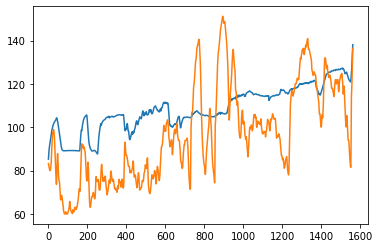

6-TS:(18.077463, 19.296259)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 7, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 28.35344


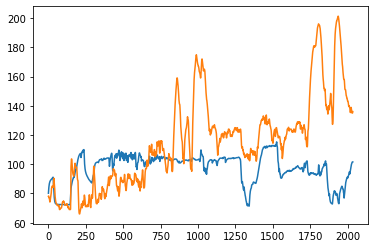

7-TS:(27.226273, 33.42184)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 0, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 30.229742


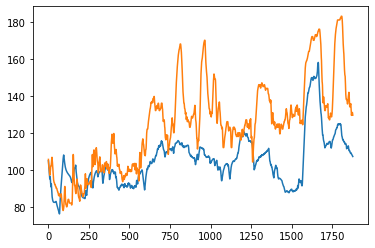

0-TS:(21.002693, 23.011522)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 2, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 11.337254


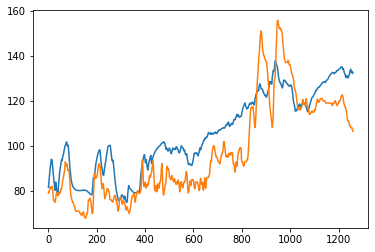

2-TS:(10.982543, 11.339591)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 3, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 18.683455


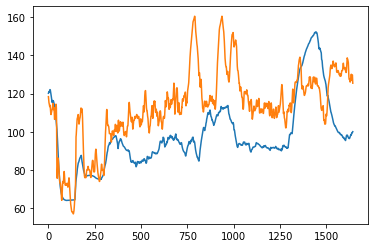

3-TS:(19.722813, 20.087334)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 4, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 12.121628


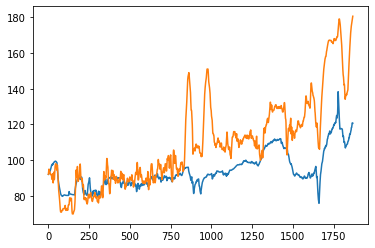

4-TS:(16.752747, 17.917072)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 5, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 13.307412


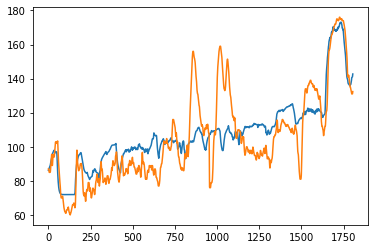

5-TS:(12.079313, 15.834014)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 6, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 18.387548


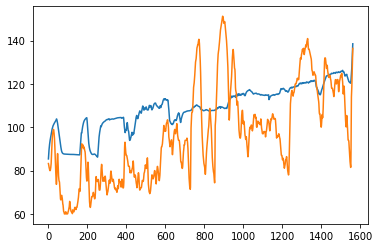

6-TS:(18.060001, 19.114515)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 7, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 31.040262


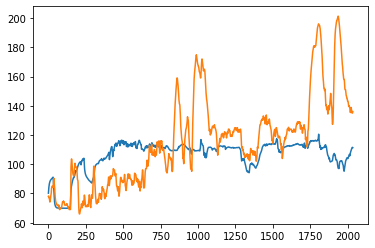

7-TS:(21.20715, 32.945526)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 1, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 13.05065


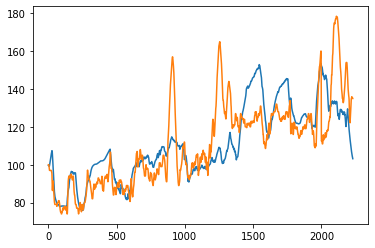

1-TS:(11.641394, 14.80335)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 2, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 9.647335


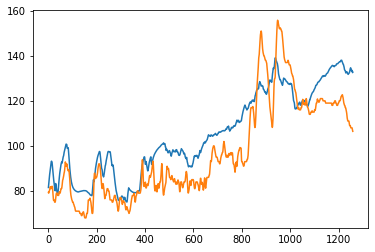

2-TS:(10.671613, 11.001141)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 3, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 18.791914


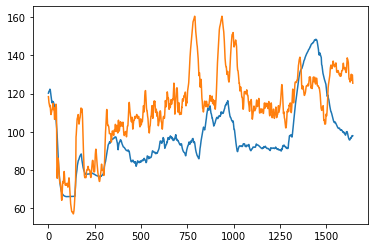

3-TS:(19.436811, 19.828249)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 4, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 14.280108


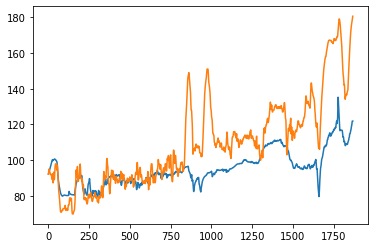

4-TS:(16.007296, 17.18968)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 5, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 15.211756


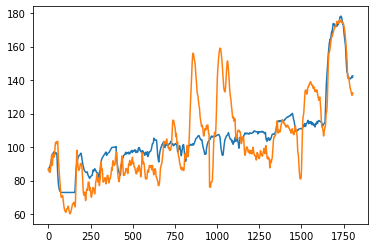

5-TS:(11.479268, 15.709562)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 6, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 19.891745


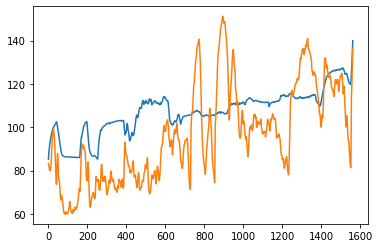

6-TS:(17.81525, 19.244055)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 7, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 26.328129


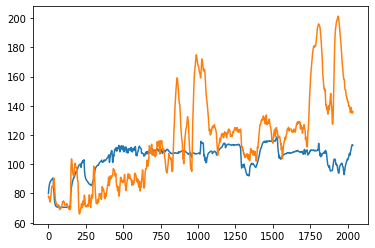

7-TS:(21.6179, 31.842625)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 0, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 17.878273


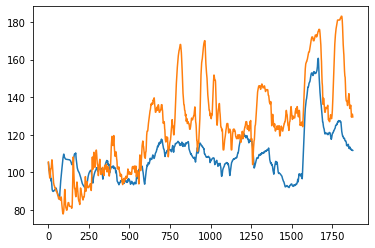

0-TS:(18.823225, 22.15598)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 1, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 15.817508


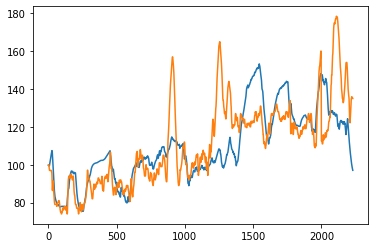

1-TS:(12.095664, 14.972378)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 2, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 11.525922


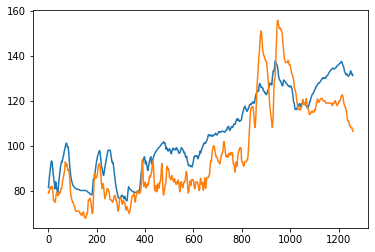

2-TS:(10.771482, 11.088604)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 3, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 20.825008


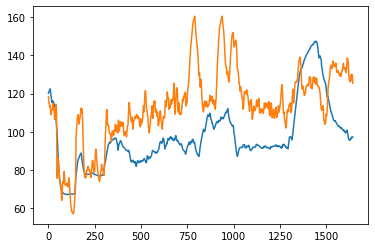

3-TS:(19.654974, 19.994375)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 4, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 21.782158


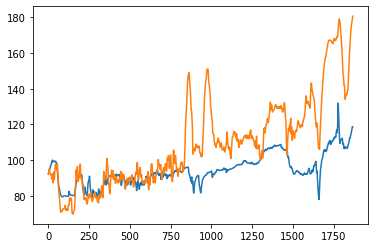

4-TS:(16.89017, 17.955091)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 5, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 23.77693


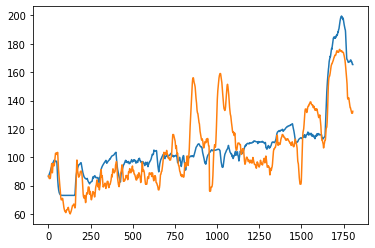

5-TS:(13.306633, 17.054123)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 7, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 32.29637


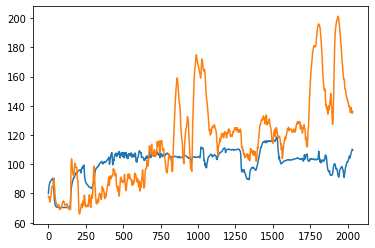

7-TS:(22.673885, 31.907446)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 0, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 32.726418


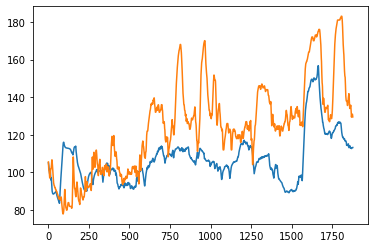

0-TS:(20.66645, 23.666044)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 1, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 14.799666


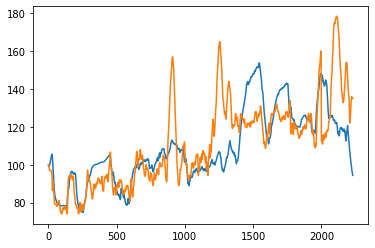

1-TS:(12.267544, 14.947704)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 2, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 8.129363


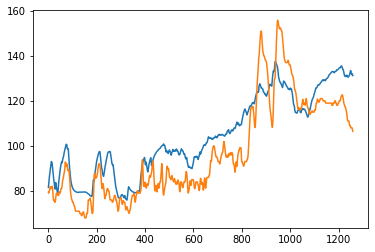

2-TS:(10.225488, 10.665855)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 3, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 15.2736635


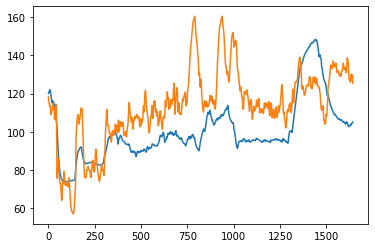

3-TS:(17.522959, 19.319986)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 4, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 14.783116


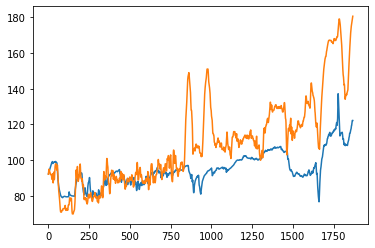

4-TS:(16.367207, 17.501953)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 5, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 16.038979


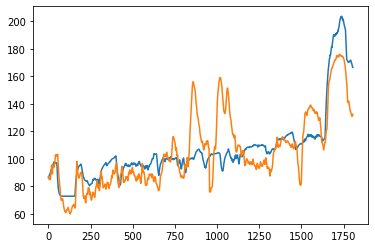

5-TS:(13.137459, 16.909103)
{'net_args': {'layer_sizes': (16, 16, 16), 'skip_mapping': ((0, 2), (0, 3), (1, 3)), 'dropout_rate': 0.1, 'input_features': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_sample': 30, 'ts_sub': 6, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.005} 14.619072


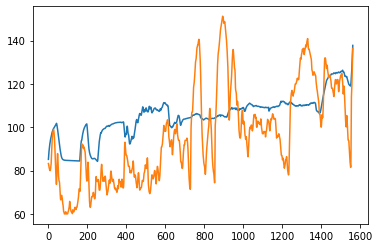

6-TS:(16.925034, 18.583342)


In [ ]:

fchoice = {
    'layer_sizes': (16, 16, 16),
    'skip_mapping': ((0, 2), (0, 3), (1, 3)),
    'dropout_rate': 0.1,
    'input_features': 7,
    'period_s': 4,
    'step_s': 2,
    'ts_per_sample': 30,
    'ts_sub': 5,
    'batch_size': 64,
    'weight_decay': 1e-05,
    'lr': 0.005
}


from PPG import UtilitiesDataXY
from collections import defaultdict
nepoch = 100
aresults = defaultdict(dict)
for val_sub in [4,5,3,2,1,0,6,7]:
  for ts_sub in range(8):
    if val_sub == ts_sub:
      continue
    fchoice["ts_sub"] = ts_sub
    # fchoice["val_sub"] = val_sub
    filename = f"pamap_ts_ffnn_{ts_sub}_val_{val_sub}_nepoch_{nepoch}.pkl"
    save_path = os.path.join(STORE_DIR, filename)
    try:
      with open(save_path , "rb") as f:
        out = pickle.load(f)
    except FileNotFoundError:
      full_trainer = RegressionHR.FullTrainer.IteractiveFFNNFullTrainerJointValidation(dfs_train, args["device"], nepoch)
      try:
        out = full_trainer.train(**fchoice)
        with open(save_path, "wb") as f:
          pickle.dump(out, f)

      except RuntimeError as e:
        if isinstance(e, KeyboardInterrupt):
          raise e
        else:
          print("####")
          print(f"Failed: {choice}")
          print("###")
    
    print(out["args"], out["metric"])
    aresults[ts_sub][val_sub] = out
    print(f"{ts_sub}-TS:{compute_ensemble(list(aresults[ts_sub].values()))}")
    



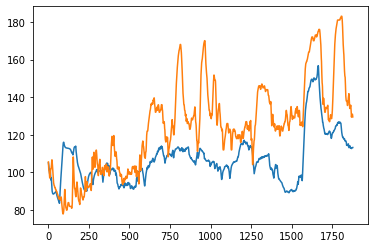

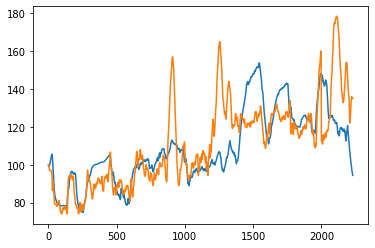

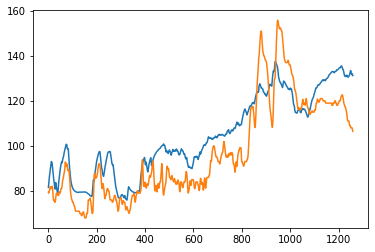

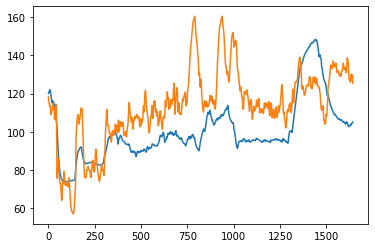

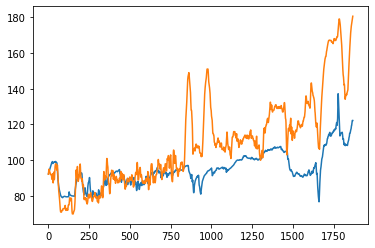

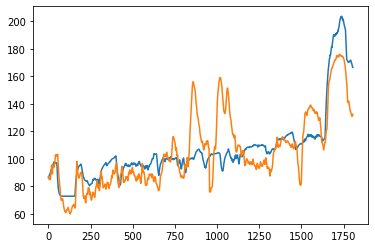

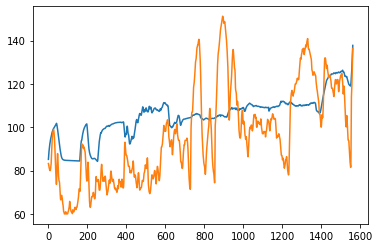

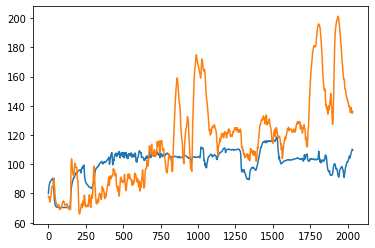

{0: (20.66645, 23.666044),
 1: (12.267544, 14.947704),
 2: (10.225488, 10.665855),
 3: (17.522959, 19.319986),
 4: (16.367207, 17.501953),
 5: (13.137459, 16.909103),
 6: (16.925034, 18.583342),
 7: (22.673885, 31.907446)}

In [ ]:
metrics = dict()
for ts_sub in range(8):
  metrics[ts_sub] = (compute_ensemble(list(aresults[ts_sub].values())))
  
metrics